# **Save this file as studentid1_studentid2_lab2.ipynb**
(Your student-id is the number shown on your student card.)

E.g. if you work with 3 people, the notebook should be named:
12301230_3434343_1238938934_lab2.ipynb.

**This will be parsed by a regexp, so please double check your filename.**

Before you turn this problem in, please make sure everything runs correctly. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Note, that **you are not allowed to use Google Colab**.

**Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names and email adresses below.**



In [ ]:
NAME = "Stefan Reuther"
NAME2 = "Wout Kooijman"
EMAIL = "stefan.reuther@outlook.com"
EMAIL2 = "wapkooijman@gmail.com"

# Lab 2: Classification

### Machine Learning 1, November 2018

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Use the provided test cells to check if your answers are correct
* **Make sure your output and plots are correct before handing in your assignment with Kernel -> Restart & Run All**

* **If possible, all your implementations should be vectorized and rely on loops as little as possible. Therefore for some questions, we give you a maximum number of loops that are necessary for an efficient implementation. This number refers to the loops in this particular function and does not count the ones in functions that are called from the function. You should not go above this number for the maximum number of points.**

$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bq}{\mathbf{q}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\bh}{\mathbf{h}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bV}{\mathbf{V}}$

In [2]:
%pylab inline
plt.rcParams["figure.figsize"] = [9,5]

import time
start = time.time()

Populating the interactive namespace from numpy and matplotlib


In [3]:
# This cell makes sure that you have all the necessary libraries installed

import sys
import platform
from importlib.util import find_spec, module_from_spec

def check_newer_version(version_inst, version_nec):
    version_inst_split = version_inst.split('.')
    version_nec_split = version_nec.split('.')
    for i in range(min(len(version_inst_split), len(version_nec_split))):
        if int(version_nec_split[i]) > int(version_inst_split[i]):
            return False
        elif int(version_nec_split[i]) < int(version_inst_split[i]):
            return True
    return True
        
    
module_list = [('jupyter', '1.0.0'), 
               ('matplotlib', '2.0.2'), 
               ('numpy', '1.13.1'), 
               ('python', '3.6.2'), 
               ('sklearn', '0.19.0'), 
               ('scipy', '0.19.1'), 
               ('nb_conda', '2.2.1')]

packages_correct = True
packages_errors = []

for module_name, version in module_list:
    if module_name == 'scikit-learn':
        module_name = 'sklearn'
    if module_name == 'pyyaml':
        module_name = 'yaml'
    if 'python' in module_name:
        python_version = platform.python_version()
        if not check_newer_version(python_version, version):
            packages_correct = False
            error = f'Update {module_name} to version {version}. Current version is {python_version}.'
            packages_errors.append(error) 
            print(error)
    else:
        spec = find_spec(module_name)
        if spec is None:
            packages_correct = False
            error = f'Install {module_name} with version {version} or newer, it is required for this assignment!'
            packages_errors.append(error) 
            print(error)
        else:
            x =__import__(module_name)
            if hasattr(x, '__version__') and not check_newer_version(x.__version__, version):
                packages_correct = False
                error = f'Update {module_name} to version {version}. Current version is {x.__version__}.'
                packages_errors.append(error) 
                print(error)

try:
    from google.colab import drive
    packages_correct = False
    error = """Please, don't use google colab!
It will make it much more complicated for us to check your homework as it merges all the cells into one."""
    packages_errors.append(error) 
    print(error)
except:
    pass

packages_errors = '\n'.join(packages_errors)

# Part 1. Multiclass logistic regression

Scenario: you have a friend with one big problem: she's completely blind. You decided to help her: she has a special smartphone for blind people, and you are going to develop a mobile phone app that can do _machine vision_ using the mobile camera: converting a picture (from the camera) to the meaning of the image. You decide to start with an app that can read handwritten digits, i.e. convert an image of handwritten digits to text (e.g. it would enable her to read precious handwritten phone numbers).

A key building block for such an app would be a function `predict_digit(x)` that returns the digit class of an image patch $\bx$. Since hand-coding this function is highly non-trivial, you decide to solve this problem using machine learning, such that the internal parameters of this function are automatically learned using machine learning techniques.

The dataset you're going to use for this is the MNIST handwritten digits dataset (`http://yann.lecun.com/exdb/mnist/`). You can download the data with scikit learn, and load it as follows:

In [110]:
from sklearn.datasets import fetch_mldata
import os
# Fetch the data
try:
    mnist = fetch_mldata('MNIST original', data_home='.')
except Exception:
    raise FileNotFoundError('Please download mnist-original.mat from Canvas and put it in %s/mldata' % os.getcwd())
data, target = mnist.data, mnist.target.astype('int')
# Shuffle
indices = np.arange(len(data))
np.random.seed(123)
np.random.shuffle(indices)
data, target = data[indices].astype('float32'), target[indices]

# Normalize the data between 0.0 and 1.0:
data /= 255. 

# Split
x_train, x_valid, x_test = data[:50000], data[50000:60000], data[60000: 70000]
t_train, t_valid, t_test = target[:50000], target[50000:60000], target[60000: 70000]

MNIST consists of small 28 by 28 pixel images of written digits (0-9). We split the dataset into a training, validation and testing arrays. The variables `x_train`, `x_valid` and `x_test` are $N \times M$ matrices, where $N$ is the number of datapoints in the respective set, and $M = 28^2 = 784$ is the dimensionality of the data. The second set of variables `t_train`, `t_valid` and `t_test` contain the corresponding $N$-dimensional vector of integers, containing the true class labels.

Here's a visualisation of the first 8 digits of the trainingset:

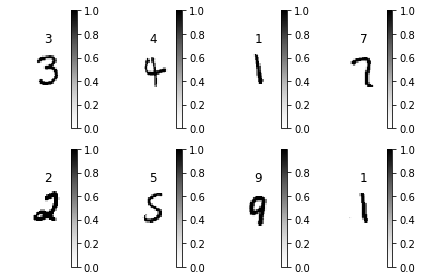

In [4]:
def plot_digits(data, num_cols, targets=None, shape=(28,28)):
    num_digits = data.shape[0]
    num_rows = int(num_digits/num_cols)
    for i in range(num_digits):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(data[i].reshape(shape), interpolation='none', cmap='Greys')
        if targets is not None:
            plt.title(int(targets[i]))
        plt.colorbar()
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_digits(x_train[0:40000:5000], num_cols=4, targets=t_train[0:40000:5000])

In _multiclass_ logistic regression, the conditional probability of class label $j$ given the image $\bx$ for some datapoint is given by:

$ \log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $\log q_j = \bw_j^T \bx + b_j$ (the log of the unnormalized probability of the class $j$), and $Z = \sum_k q_k$ is the normalizing factor. $\bw_j$ is the $j$-th column of $\bW$ (a matrix of size $784 \times 10$) corresponding to the class label, $b_j$ is the $j$-th element of $\bb$.

Given an input image, the multiclass logistic regression model first computes the intermediate vector $\log \bq$ (of size $10 \times 1$), using $\log q_j = \bw_j^T \bx + b_j$, containing the unnormalized log-probabilities per class. 

The unnormalized probabilities are then normalized by $Z$ such that $\sum_j p_j = \sum_j \exp(\log p_j) = 1$. This is done by $\log p_j = \log q_j - \log Z$ where $Z = \sum_i \exp(\log q_i)$. This is known as the _softmax_ transformation, and is also used as a last layer of many classifcation neural network models, to ensure that the output of the network is a normalized distribution, regardless of the values of second-to-last layer ($\log \bq$)

**Warning**: when computing $\log Z$, you are likely to encounter numerical problems. Save yourself countless hours of debugging and learn the [log-sum-exp trick](https://www.xarg.org/2016/06/the-log-sum-exp-trick-in-machine-learning/ "Title").

The network's output $\log \bp$ of size $10 \times 1$ then contains the conditional log-probabilities $\log p(t = j \;|\; \bx, \bb, \bW)$ for each digit class $j$. In summary, the computations are done in this order:

$\bx \rightarrow \log \bq \rightarrow Z \rightarrow \log \bp$

Given some dataset with $N$ independent, identically distributed datapoints, the log-likelihood is given by:

$ \mathcal{L}(\bb, \bW) = \sum_{n=1}^N \mathcal{L}^{(n)}$

where we use $\mathcal{L}^{(n)}$ to denote the partial log-likelihood evaluated over a single datapoint. It is important to see that the log-probability of the class label $t^{(n)}$ given the image, is given by the $t^{(n)}$-th element of the network's output $\log \bp$, denoted by $\log p_{t^{(n)}}$:

$\mathcal{L}^{(n)} = \log p(t = t^{(n)} \;|\; \bx = \bx^{(n)}, \bb, \bW) = \log p_{t^{(n)}} = \log q_{t^{(n)}} - \log Z^{(n)}$

where $\bx^{(n)}$ and $t^{(n)}$ are the input (image) and class label (integer) of the $n$-th datapoint, and $Z^{(n)}$ is the normalizing constant for the distribution over $t^{(n)}$.


## 1.1 Gradient-based stochastic optimization
### 1.1.1 Derive gradient equations (20 points)

Derive the equations for computing the (first) partial derivatives of the log-likelihood w.r.t. all the parameters, evaluated at a _single_ datapoint $n$.

You should start deriving the equations for $\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$ for each $j$. For clarity, we'll use the shorthand $\delta^q_j = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$.

For $j = t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log p_j}
\frac{\partial \log p_j}{\partial \log q_j}
+ \frac{\partial \mathcal{L}^{(n)}}{\partial \log Z}
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= \frac{\partial \mathcal\log q_j}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= 1  - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$$

For $j \neq t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log Z}
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$$

Complete the above derivations for $\delta^q_j$ by furtherly developing $\frac{\partial \log Z}{\partial Z}$ and $\frac{\partial Z}{\partial \log q_j}$. Both are quite simple. For these it doesn't matter whether $j = t^{(n)}$ or not.



For $j = t^{(n)}$:
\begin{align}
\delta^q_j
&= 1- \frac{\partial log z}{\partial z} \frac{\partial z}{\partial log q_j} 
= 1 - \frac{1}{Z} \frac{\partial Z}{\partial u_i} \frac{\partial u_i}{\partial log q_j}
= 1 - \frac{1}{Z} \frac{\sum_i exp(log u_i)}{\partial u_j} * 1
= 1 - \frac{exp(log q_j)}{\sum_i exp(log q_i)}
\end{align}
For $j \neq t^{(n)}$:
\begin{align}
\delta^q_j
&= - \frac{exp(log q_j)}{\sum_i exp(log q_i)}
\end{align}

Given your equations for computing the gradients $\delta^q_j$ it should be quite straightforward to derive the equations for the gradients of the parameters of the model, $\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}}$ and $\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}$. The gradients for the biases $\bb$ are given by:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial b_j}
= \delta^q_j
\cdot 1
= \delta^q_j
$

The equation above gives the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element of $\bb$, so the vector $\nabla_\bb \mathcal{L}^{(n)}$ with all derivatives of $\mathcal{L}^{(n)}$ w.r.t. the bias parameters $\bb$ is: 

$
\nabla_\bb \mathcal{L}^{(n)} = \mathbf{\delta}^q
$

where $\mathbf{\delta}^q$ denotes the vector of size $10 \times 1$ with elements $\mathbf{\delta}_j^q$.

The (not fully developed) equation for computing the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element $W_{ij}$ of $\bW$ is:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
$

What is $\frac{\partial \log q_j}{\partial W_{ij}}$? Complete the equation above.

If you want, you can give the resulting equation in vector format ($\nabla_{\bw_j} \mathcal{L}^{(n)} = ...$), like we did for $\nabla_\bb \mathcal{L}^{(n)}$.

$ \frac{\partial log q_j}{\partial W_{ij}}$ where $log q_j = w_j^T x +b_j
\frac{\partial log q_j}{\partial W_{ij}} 
= \frac{w_j^T x +b_j}{W_{ij}} = x_i $

So 

$\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}}
= \mathbf{\delta}_j^q x_i $


### 1.1.2 Implement gradient computations (15 points)

Implement the gradient calculations you derived in the previous question. Write a function `logreg_gradient(x, t, w, b)` that returns the gradients $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (for each $j$) and $\nabla_{\bb} \mathcal{L}^{(n)}$, i.e. the first partial derivatives of the log-likelihood w.r.t. the parameters $\bW$ and $\bb$, evaluated at a single datapoint (`x`, `t`).
The computation will contain roughly the following intermediate variables:

$
\log \bq \rightarrow Z \rightarrow \log \bp\,,\, \mathbf{\delta}^q
$

followed by computation of the gradient vectors $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (contained in a $784 \times 10$ matrix) and $\nabla_{\bb} \mathcal{L}^{(n)}$ (a $10 \times 1$ vector).

For maximum points, ensure the function is numerically stable.


In [20]:
# 1.1.2 Compute gradient of log p(t|x;w,b) wrt w and b
def logreg_gradient(x, t, W, b):
    
    log_q = np.matmul(W.transpose(), x.flatten()) + b

    # Computing log Z using the log-sum-exp trick
    a = log_q.max()
    log_Z = a + np.log(np.exp(log_q - a).sum())

    log_p = log_q - log_Z

    delta = - np.exp(log_q) / np.exp(log_q).sum()
    delta[t] = 1 - np.exp(log_q[t]) / np.exp(log_q).sum()

    dL_dw = delta * x.transpose()
    dL_db = delta.transpose()

    # here the statement contains logp[:,t] where logp is meant tas a matrix of shape 1x10
    return log_p[t].squeeze(), dL_dw, dL_db.squeeze()


In [6]:
# Hidden tests for efficiency

In [21]:
np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

# test gradients, train on 1 sample
logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)

print("Test gradient on one point")
print("Log Likelihood:\t", logpt)
print("\nGrad_W_ij\t",grad_w.shape,"matrix")
print("Grad_W_ij[0,152:158]=\t", grad_w[152:158,0])
print("\nGrad_B_i shape\t",grad_b.shape,"vector")
print("Grad_B_i=\t", grad_b.T)
print("i in {0,...,9}; j in M")

assert logpt.shape == (), logpt.shape
assert grad_w.shape == (784, 10), grad_w.shape
assert grad_b.shape == (10,), grad_b.shape




Test gradient on one point
Log Likelihood:	 -2.2959726720744777

Grad_W_ij	 (784, 10) matrix
Grad_W_ij[0,152:158]=	 [-0.04518971 -0.06758809 -0.07819784 -0.09077237 -0.07584012 -0.06365855]

Grad_B_i shape	 (10,) vector
Grad_B_i=	 [-0.10020327 -0.09977827 -0.1003198   0.89933657 -0.10037941 -0.10072863
 -0.09982729 -0.09928672 -0.09949324 -0.09931994]
i in {0,...,9}; j in M


In [8]:
# It's always good to check your gradient implementations with finite difference checking:
# Scipy provides the check_grad function, which requires flat input variables.
# So we write two helper functions that provide the gradient and output with 'flat' weights:
from scipy.optimize import check_grad

np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

def func(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return logpt
def grad(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return grad_w.flatten()
finite_diff_error = check_grad(func, grad, w.flatten())
print('Finite difference error grad_w:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for w seems off'

def func(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return logpt
def grad(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return grad_b.flatten()
finite_diff_error = check_grad(func, grad, b)
print('Finite difference error grad_b:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for b seems off'



Finite difference error grad_w: 6.411502523780485e-07
Finite difference error grad_b: 5.235117497507527e-08


In [9]:
# DO NOT REMOVE THIS CELL!
# It contains hidden tests



### 1.1.3 Stochastic gradient descent (15 points)

Write a function `sgd_iter(x_train, t_train, w, b)` that performs one iteration of stochastic gradient descent (SGD), and returns the new weights. It should go through the trainingset once in randomized order, call `logreg_gradient(x, t, w, b)` for each datapoint to get the gradients, and update the parameters **using a small learning rate of `1e-6`**. Note that in this case we're maximizing the likelihood function, so we should actually performing gradient ___ascent___... For more information about SGD, see Bishop 5.2.4 or an online source (i.e. https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

In [22]:
def sgd_iter(x_train, t_train, W, b):
    learning_rate = 1e-4

    # Size of trainingset
    N = len(t_train)

    logp_train = 1
    # Go through trainingset in randomized order
    for i in np.random.choice(N, N, replace=True):
        # Get gradient
        logp, dL_dw, dL_db = logreg_gradient(x_train[i:i+1, :], t_train[i:i+1], W, b)
        logp_train += logp
        # Update bias and weights (plus-sign due to maximizing)
        b = b + learning_rate * dL_db
        W = W + learning_rate * dL_dw

    return logp_train, W, b

In [11]:
# Hidden tests for efficiency

In [23]:
# Sanity check:
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
    
logp_train, W, b = sgd_iter(x_train[:5], t_train[:5], w, b)




## 1.2. Train

### 1.2.1 Train (12 points)
Perform SGD on the training set. Plot (in one graph) the conditional log-probability of the training set and validation set after each iteration. (6 points)

Instead of running SGD for a fixed number of steps, run it until convergence. Think of a reasonable criterion for determining convergence. As a reference: choose a criterion such that the algorithm terminates in less than 15 iterations over the training set. (2 points)

Make sure your implementation (in particular, the output of the conditional log-probability of the training set and validation set) is independent of the size of the dataset. (2 points)

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11


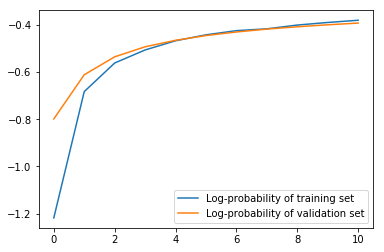

In [24]:
def test_sgd(x_train, t_train, x_valid, t_valid, W, b):
    eps = 1e-2
    # Perform SGD
    probs_train = []
    probs_valid = []
    i = 0
    while True:
        print("Iteration {}".format(i + 1))
        # Train network weights
        logp_train, W, b = sgd_iter(x_train, t_train, W, b)

        # Validate the trained weights using the validation set
        logp_valid = 0
        for n in range(len(t_valid)):
            logp, _, _ = logreg_gradient(x_valid[n:n + 1, :], t_valid[n:n + 1], W, b)
            logp_valid += logp

        probs_train.append(logp_train / len(t_train))
        probs_valid.append(logp_valid / len(t_valid))
        i += 1
        # Stop training early as soon as the validation log-prob is smaller
        # than the training log-prob. Difference needs to greater than an epsilon because
        # of random effects in SGD
        if probs_train[-1] - probs_valid[-1] > eps:
            break

    # Plot log-probabilities
    plt.plot(probs_train, label="Log-probability of training set")
    plt.plot(probs_valid, label="Log-probability of validation set")
    plt.legend()
    plt.show()

    return W, b
    
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
w,b = test_sgd(x_train, t_train, x_valid, t_valid, w, b)

In [14]:
# Hidden tests for efficiency

### 1.2.2 Visualize weights (10 points)
Visualize the resulting parameters $\bW$ after a few iterations through the training set, by treating each column of $\bW$ as an image. If you want, you can use or edit the `plot_digits(...)` above.


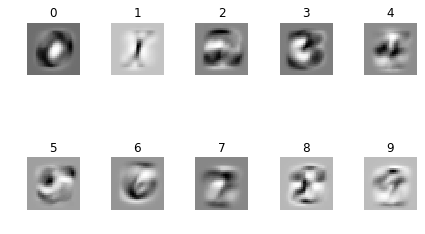

In [15]:
data = w.transpose()
num_cols = 5
targets = np.arange(0, 10)
shape = (28, 28)

# Modified plot_digits() function
num_digits = data.shape[0]
num_rows = int(num_digits / num_cols)
for i in range(num_digits):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(data[i].reshape(shape), interpolation='none', cmap='Greys')
    plt.title(int(targets[i]))
    plt.axis('off')
plt.tight_layout()
plt.show()

**Describe in less than 100 words why these weights minimize the loss**

In the plots, it can be seen that the outer boundary of the image matrix is "grayed out" in a circular shape. A gray color means that the corresponding weight values are close to zero. In this area, no meaningfull information is available, because of the digit's central position. The weights therefore remain close to zero.

The inner part of the weight image shows a blurry representation of the corresponding digit. The blurriness refelects the approximation of the examples in the training set. 

### 1.2.3. Visualize the 8 hardest and 8 easiest digits (10 points)
Visualize the 8 digits in the validation set with the highest probability of the true class label under the model.
Also plot the 8 digits that were assigned the lowest probability.


In [19]:
def plot_digits_mod(data, num_cols, targets, title):
    shape = (28, 28)
    num_digits = data.shape[0]
    num_rows = int(num_digits / num_cols)
    for i in range(num_digits):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(data[i].reshape(shape), interpolation='none', cmap='Greys')
        plt.title(int(targets[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

# Loop over validation set
probs = []
for n in range(len(t_valid)):
    logp, _, _ = logreg_gradient(x_valid[n:n + 1, :], t_valid[n:n + 1], w, b)
    probs.append(float(logp))

ind_max8 = np.asarray(probs).argsort()[-8:][::-1]
ind_min8 = np.asarray(probs).argsort()[:8]

# Plot the 8 easiest digits
plot_digits_mod(x_valid[ind_max8, :], 4, t_valid[ind_max8], "The 8 easiest digits")
# Plot the 8 hardest digits
plot_digits_mod(x_valid[ind_min8, :], 4, t_valid[ind_min8], "The 8 hardest digits")

NameError: name 'logreg_gradient' is not defined

Ask yourself if these results make sense. Explain in no more then two sentences what it means that a digit is hard to classify.

- When a digit is hard to classify it means that the digit has two or more classes that have a relatively close probability as being classified in that class.

# Part 2. Multilayer perceptron


You discover that the predictions by the logistic regression classifier are not good enough for your application: the model is too simple. You want to increase the accuracy of your predictions by using a better model. For this purpose, you're going to use a multilayer perceptron (MLP), a simple kind of neural network. The perceptron will have a single hidden layer $\bh$ with $L$ elements. The parameters of the model are $\bV$ (connections between input $\bx$ and hidden layer $\bh$), $\ba$ (the biases/intercepts of $\bh$), $\bW$ (connections between $\bh$ and $\log q$) and $\bb$ (the biases/intercepts of $\log q$).

The conditional probability of the class label $j$ is given by:

$\log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $q_j$ are again the unnormalized probabilities per class, and $Z = \sum_j q_j$ is again the probability normalizing factor. Each $q_j$ is computed using:

$\log q_j = \bw_j^T \bh + b_j$

where $\bh$ is a $L \times 1$ vector with the hidden layer activations (of a hidden layer with size $L$), and $\bw_j$ is the $j$-th column of $\bW$ (a $L \times 10$ matrix). Each element of the hidden layer is computed from the input vector $\bx$ using:

$h_j = \sigma(\bv_j^T \bx + a_j)$

where $\bv_j$ is the $j$-th column of $\bV$ (a $784 \times L$ matrix), $a_j$ is the $j$-th element of $\ba$, and $\sigma(.)$ is the so-called sigmoid activation function, defined by:

$\sigma(x) = \frac{1}{1 + \exp(-x)}$

Note that this model is almost equal to the multiclass logistic regression model, but with an extra 'hidden layer' $\bh$. The activations of this hidden layer can be viewed as features computed from the input, where the feature transformation ($\bV$ and $\ba$) is learned.

## 2.1 Derive gradient equations (20 points)

State (shortly) why $\nabla_{\bb} \mathcal{L}^{(n)}$ is equal to the earlier (multiclass logistic regression) case, and why $\nabla_{\bw_j} \mathcal{L}^{(n)}$ is almost equal to the earlier case.

Like in multiclass logistic regression, you should use intermediate variables $\mathbf{\delta}_j^q$. In addition, you should use intermediate variables $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial h_j}$.

Given an input image, roughly the following intermediate variables should be computed:

$
\log \bq \rightarrow Z \rightarrow \log \bp \rightarrow \mathbf{\delta}^q \rightarrow \mathbf{\delta}^h
$

where $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j}$.

Give the equations for computing $\mathbf{\delta}^h$, and for computing the derivatives of $\mathcal{L}^{(n)}$ w.r.t. $\bW$, $\bb$, $\bV$ and $\ba$. 

You can use the convenient fact that $\frac{\partial}{\partial x} \sigma(x) = \sigma(x) (1 - \sigma(x))$.

YOUR ANSWER HERE

$\delta^q_j = - \frac{exp(log q_j)}{\sum_i exp(log q_i)}$

$\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j} = \frac{\partial \mathcal{L}^{(n)}}{\partial log q}\frac{\partial log q}{\partial h} = \delta_j^q W^T$

$\nabla_{\bb} \mathcal{L}^{(n)} = \delta^q_j$

$\nabla_{W} \mathcal{L}^{(n)} = \delta^q h$

$\nabla_{a} \mathcal{L}^{(n)} = \delta^h_j$

$\nabla_{V} \mathcal{L}^{(n)} = \delta^hx$

## 2.2 MAP optimization (10 points)

You derived equations for finding the _maximum likelihood_ solution of the parameters. Explain, in a few sentences, how you could extend this approach so that it optimizes towards a _maximum a posteriori_ (MAP) solution of the parameters, with a Gaussian prior on the parameters. 

To create a MAP solution we need to have a Gaussian prior $p(w|\alpha) = \mathcal{N}(w|0, \alpha^{-1} \bI)$. We will need to set an $\alpha$ for this to calculate the MAP.

## 2.3. Implement and train a MLP (15 points)

Implement an MLP model with a single hidden layer of **20 neurons**. 
Train the model for **10 epochs**.
Test your implementation for learning rates of 1e-2, 1e-3 and 1e-4 and plot (in one graph) the conditional log-probability of the trainingset and validation set. 

For the best model plot the weights of the first layer for in epoch 0,4 and 9. 


- 10 points: Working MLP that learns with plots
- +5 points: Fast, numerically stable, vectorized implementation

In [396]:
import numpy as np

def sigmoid(x):
    return 1. / (1. + np.exp(-x))

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum() 

def cross_entropy(y, t):
    N = y.shape[0]
    return -np.sum(t*np.log(y))/N

def make_one_hot(x):
    x = x.astype(int)
    y = np.zeros((x.size, x.max()+1))
    y[np.arange(x.size), x] = 1
    return y

def update_weight(x, grad, lr):
    y = lr * grad
    return x - y

def calculate_delta(x, h, y, V, a, W, b):
    delta_q = (- np.exp(y)/np.sum(np.exp(y)))
    assert delta_q.shape == y.shape
    
    dW = np.matmul(h.transpose(), delta_q)
    assert dW.shape == W.shape
    
    db = np.sum(delta_q)
    delta_h = np.dot(delta_q, W.transpose())
    assert delta_h.shape == h.shape
    
    dV = np.dot(x.transpose(), delta_h)
    assert dV.shape == V.shape
    
    da = np.sum(delta_h)
    
    return dV, da, dW, db


    
def forward_pass_mlp(x, t, V, a, W, b):
    z1 = np.add(np.matmul(x, V), a)
    h = sigmoid(z1)
    
    assert h.shape == (1, 20), h.shape
    
    z2 = np.add(np.matmul(h, W), b)
    y = softmax(z2)

    assert y.shape == (1,10), y.shape

    loss = cross_entropy(y, t)
    
    return h, y, loss

def backwards_pass(x, h, y, V, a, W, b, lr):
    dV, da, dW, db = calculate_delta(x, h, y, V, a, W, b)
    
    V_new = update_weight(V, dV, lr)
    a_new = update_weight(a, da, lr)
    W_new = update_weight(W, dW, lr)
    b_new = update_weight(b, db, lr)
    
    assert V_new.shape == (28*28, 20), V_new.shape
    assert a_new.shape == (1, 20), a_new.shape
    assert W_new.shape == (20, 10), W_new.shape
    assert b_new.shape == (1, 10), b_new.shape
    
    
    
    return V_new, a_new, W_new, b_new

def mlp(x_train, t_train, x_valid, t_valid, V, a, W, b, learning_rate=1e-2):

    num_epochs = 10
    N = len(t_train)
    
    t = make_one_hot(t_train)
    t_valid = make_one_hot(t_valid)
    
    loss_train = 0
    loss_valid = 0
    count_train = 0
    
    for i in range(0, num_epochs):
        print("Iteration " + str(i))
        loss_train_int = 0
        
        # Train on trainset
        print("Training...")
        for j in np.random.choice(N, N, replace=True):
            x = np.reshape(x_train[j], (len(x_train[j]), 1)).transpose()
            h, y, lt = forward_pass_mlp(x, t[j], V, a, W, b)
            V, a, W, b = backwards_pass(x, h, y, V, a, W, b, learning_rate)
            loss_train_int += lt
            count_train += 1

        # Validate on validationset    
        print("Validating...")
        loss_valid_int = 0
        for k in range(len(t_valid)):
            x = np.reshape(x_valid[k], (len(x_valid[k]), 1)).transpose()
            _, _, lv = forward_pass_mlp(x, t_valid, V, a, W, b)
            loss_valid_int += lv
            break
            
        #Calculate total loss
        loss_train += loss_train_int/count_train
        print("Loss train: " + str(loss_train))
        loss_valid += loss_valid_int/len(t_valid)
        print("Loss validation: " + str(loss_valid))
        break
    
    print("Done")
    return loss_train/num_epochs, loss_valid/num_epochs

In [ ]:
# Hidden tests for efficiency

In [397]:
# learning rate = 1e-2
# hidden layer = 20x1 - Sigmoid activation
# Output layer = 10x1 - Softmax activation

# train model for 10 epochs 

# input = NxM where N is amount of datapoints and M = 28*28
# bias has to be pressent
# W1 = MxM
# W2 = 

## forward pass
# input x * W1 -> hidden layer
# hidden_layer * W2 -> Output

   
np.random.seed(1243)
M = 28*28
# hidden layer size 20x1
N = 20
# output size 10x1
O = 10
input_size = x_train.shape[0]

# x_train = (NxM)
V = np.random.normal(size=(M,N), scale=0.001)
W = np.random.normal(size=(N,O), scale=0.001)
a = np.zeros(shape=(1, N))
b = np.zeros(shape=(1, O))

loss_train_2, loss_valid_2 = mlp(x_train, t_train, x_valid, t_valid, V, a, W, b, learning_rate=1e-2)
# loss_train_3, loss_valid_3 = mlp(x_train, t_train, x_valid, t_valid, V, a, W, b, learning_rate=1e-3)
# loss_train_4, loss_valid_4 = mlp(x_train, t_train, x_valid, t_valid, V, a, W, b, learning_rate=1e-4)

Iteration 0
Training...
2.3041696177723754
1
4.605135717094516
2
6.909814928622106
3
9.209605779536055
4
11.509405529497274
5
13.810359044348445
6
16.11504005482207
7
18.416572443840696
8
20.718909035775955
9
23.02124668686508
10
25.3221818139996
11
27.626363159299807
12
29.931001159339402
13
32.23240575143999
14
34.53706148250251
15
36.83858747917269
16
39.140618660012784
17
41.44528127659537
18
43.74679348326706
19
46.04881467623032
20
48.35349809452851
21
50.65551023307624
22
52.957014406223685
23
55.26139395179365
24
57.56289621753719
25
59.86521223367505
26
62.16656133197308
27
64.46616948370934
28
66.76700493248492
29
69.06848637902165
30
71.37276915201129
31
73.67760758128738
32
75.97907579688211
33
78.28342173650051
34
80.58774717998963
35
82.89209567202029
36
85.19407148073674
37
87.49537608565686
38
89.79682612281665
39
92.09912687877394
40
94.40144128908307
41
96.70287309626657
42
99.00733222284894
43
101.30801749240095
44
103.60999143050475
45
105.91229040683548
46
108.2117

1577.0985102707205
685
1579.4154232838798
686
1581.7164222964955
687
1584.0174184019668
688
1586.3088491821097
689
1588.6234101100804
690
1590.9369894747367
691
1593.2540755416992
692
1595.5711906538013
693
1597.8883348693084
694
1600.1837672504682
695
1602.4984733031513
696
1604.799443029881
697
1607.0948330730437
698
1609.3778781494666
699
1611.6951982155565
700
1613.99397338309
701
1616.3113525375059
702
1618.6252004191842
703
1620.9401027239685
704
1623.241048676762
705
1625.5354834068899
706
1627.8342142536756
707
1630.1252161105242
708
1632.4392007157842
709
1634.7562797386745
710
1637.0514834510313
711
1639.35017698602
712
1641.63266569965
713
1643.9504044012692
714
1646.26452740062
715
1648.5654401579945
716
1650.8640960346086
717
1653.1814091115025
718
1655.4764958089584
719
1657.791800249496
720
1660.082499228846
721
1662.3833936303997
722
1664.6740453199752
723
1666.989452339509
724
1669.3075283096607
725
1671.6256353109266
726
1673.9206031706663
727
1676.236113600634
728
16

2737.585002849228
1189
2739.917705871232
1190
2742.199279208562
1191
2744.5399696491377
1192
2746.832971623458
1193
2749.116684809067
1194
2751.4589891885585
1195
2753.70849171569
1196
2755.9898209263984
1197
2758.2711091860306
1198
2760.6137336327006
1199
2762.862805733754
1200
2765.146264830373
1201
2767.479711316245
1202
2769.813220593059
1203
2772.1060314705132
1204
2774.3988248144906
1205
2776.7420156258095
1206
2779.085288000714
1207
2781.3567538013735
1208
2783.649476741929
1209
2785.897457268529
1210
2788.2342515052874
1211
2790.5054719486784
1212
2792.84240498496
1213
2795.1848182277777
1214
2797.5218906339596
1215
2799.8024287310786
1216
2802.1368308406813
1217
2804.4741133764273
1218
2806.754524014565
1219
2809.0252480368313
1220
2811.3055733114197
1221
2813.5882505450722
1222
2815.8708898027858
1223
2818.2141118412737
1224
2820.494265445999
1225
2822.786684334548
1226
2825.131622994957
1227
2827.4018428932122
1228
2829.739907062293
1229
2832.0851015123008
1230
2834.38375680

3655.686996042565
1588
3657.9451248705627
1589
3660.203172540339
1590
3662.4662718772547
1591
3664.763334004373
1592
3667.154365996217
1593
3669.53160563487
1594
3671.7944216659316
1595
3673.9773493044327
1596
3676.369098312828
1597
3678.7610274925296
1598
3681.0235585031533
1599
3683.3959262355384
1600
3685.7742473479816
1601
3688.0579185243637
1602
3690.4365515736395
1603
3692.8265968857336
1604
3695.2168195711984
1605
3697.4519573041116
1606
3699.842535832515
1607
3702.0774146122963
1608
3704.360891450958
1609
3706.622629780267
1610
3709.0169349955927
1611
3711.273164043267
1612
3713.6474381714424
1613
3715.930775798328
1614
3718.227825359636
1615
3720.511107213596
1616
3722.688766914586
1617
3724.9499205363854
1618
3727.3310970688904
1619
3729.564402213964
1620
3731.847544425951
1621
3734.1306586748738
1622
3736.3859543915637
1623
3738.7618836594806
1624
3741.0449139527855
1625
3743.2999523164804
1626
3745.5604398352248
1627
3747.9430853255553
1628
3750.226003529229
1629
3752.60897

2153
4963.045823572412
2154
4965.165132713241
2155
4967.711305387213
2156
4969.920938235171
2157
4972.504446370807
2158
4974.622549540373
2159
4977.199711419565
2160
4979.106464932948
2161
4981.012331523873
2162
4983.547003478534
2163
4986.126501121128
2164
4988.2427874966
2165
4990.831056309427
2166
4993.151793583789
2167
4995.360456486665
2168
4997.260050336374
2169
4999.843092407201
2170
5002.434381170936
2171
5004.54853647121
2172
5006.756770560582
2173
5008.946836047374
2174
5011.154900857964
2175
5013.43419961999
2176
5015.713566790767
2177
5017.993003034113
2178
5020.200733284743
2179
5022.523443050088
2180
5025.120876766036
2181
5027.443902326848
2182
5029.723694032246
2183
5032.285299084996
2184
5034.170121435072
2185
5036.450134645325
2186
5039.043492127849
2187
5041.607389322899
2188
5043.814307781538
2189
5045.694386351408
2190
5048.298108538314
2191
5050.485962384863
2192
5053.083059698873
2193
5055.68869705273
2194
5058.256660299189
2195
5060.463032918471
2196
5062.743913

6896.452492620178
2865
6902.119038677539
2866
6907.5969256705375
2867
6912.743686212423
2868
6917.917784018591
2869
6923.416727184258
2870
6929.823973321125
2871
6935.65494988932
2872
6940.938910668519
2873
6947.5292167
2874
6953.165971081388
2875
6959.797390902526
2876
6966.400729248008
2877
6971.82308433024
2878
6977.631979922895
2879
6984.288827054423
2880
6989.794732646234
2881
6996.5934464234415
2882
6996.61155749088
2883
7002.2013644846775
2884
7008.394201553162
2885
7015.249316662379
2886
7022.13258416148
2887
7029.114236368921
2888
7035.419682533041
2889
7042.443474072427
2890
7049.509868039438
2891
7055.900098903092
2892
7062.434107496927
2893
7069.5855035143
2894
7076.750961642967
2895
7083.3701023099675
2896
7089.685981545685
2897
7095.969179452169
2898
7101.982898462502
2899
7108.025098785996
2900
7115.275433741224
2901
7122.55432386063
2902
7129.962094584826
2903
7136.693845051309
2904
7143.569693682285
2905
7150.963014006961
2906
7157.503233965251
2907
7157.512101751637
2

16048.85059576863
3526
16048.850595768748
3527
16073.6404197442
3528
16098.79156769795
3529
16124.561457147487
3530
16149.439260667372
3531
16175.167460915902
3532
16200.435914928894
3533
16200.43591492899
3534
16200.435914929083
3535
16200.435914929174
3536
16226.396757128265
3537
16251.120327204662
3538
16277.083914387513
3539
16303.132736131041
3540
16328.242611313783
3541
16353.659438900373
3542
16379.22115806149
3543
16404.41901278867
3544
16430.039384979413
3545
16455.573518625257
3546
16481.771717926615
3547
16508.06948464278
3548
16534.382245019628
3549
16559.817252320954
3550
16585.22039265183
3551
16611.53512319662
3552
16611.535123196674
3553
16611.53512319673
3554
16638.038175516594
3555
16663.86557431058
3556
16689.444673730348
3557
16714.75477410302
3558
16714.75477410307
3559
16740.815044016028
3560
16766.511449495054
3561
16791.93885592699
3562
16791.93885592703
3563
16791.93885592707
3564
16818.720840540962
3565
16818.720840541
3566
16844.654398594183
3567
16844.654398

4144
34428.44295208134
4145
34472.263641804784
4146
34516.11365804305
4147
34559.41791866928
4148
34603.27067989131
4149
34646.63359354718
4150
34690.54500779885
4151
34733.96657448435
4152
34776.72595117401
4153
34819.514654378494
4154
34819.514654378494
4155
34863.05352712327
4156
34906.228535434115
4157
34950.31513395888
4158
34994.5314012291
4159
35037.85558256966
4160
35037.85558256966
4161
35037.85558256966
4162
35082.18915589915
4163
35082.18915589915
4164
35125.598776328545
4165
35169.3153491618
4166
35213.06124850987
4167
35256.26052292181
4168
35300.77005534021
4169
35344.603934232735
4170
35389.15778682665
4171
35433.050318748814
4172
35476.75574478202
4173
35521.34166887453
4174
35565.43774540086
4175
35609.23115097852
4176
35653.874953284845
4177
35697.727011892144
4178
35741.547203529
4179
35786.30908671042
4180
35831.10029640665
4181
35875.00846758796
4182
35918.647639722185
4183
35963.597069862866
4184
36008.47548428774
4185
36052.89415247708
4186
36097.917229308085
418

61544.796680822605
4723
61604.87744892467
4724
61664.41159209061
4725
61664.41159209061
4726
61724.004388286194
4727
61784.20246244754
4728
61845.03450093376
4729
61845.03450093376
4730
61904.744603188614
4731
61965.764963449925
4732
62025.83204429632
4733
62086.32164260629
4734
62147.42998241206
4735
62208.46730650202
4736
62268.71288689296
4737
62328.98779379871
4738
62390.14319876376
4739
62450.808756162645
4740
62512.02281415733
4741
62573.26619866684
4742
62633.904170550464
4743
62694.57146894891
4744
62694.57146894891
4745
62754.72146892604
4746
62815.59231192865
4747
62877.01165552707
4748
62937.941151559324
4749
62998.5679766429
4750
63060.04519845514
4751
63120.947108972134
4752
63182.58332604464
4753
63243.26626370223
4754
63304.0397213599
4755
63365.66357574623
4756
63426.49568643354
4757
63487.68912109916
4758
63548.57988481611
4759
63609.499975047875
4760
63609.499975047875
4761
63670.41752482401
4762
63732.33267419058
4763
63793.370070481615
4764
63854.37559980221
4765
63

82837.1887241303
5082
82908.48835823884
5083
82978.8490457866
5084
83049.30025333444
5085
83049.30025333444
5086
83119.45059486474
5087
83189.92858847177
5088
83260.49710207888
5089
83330.73542315364
5090
83330.73542315364
5091
83401.33072281996
5092
83472.34853994983
5093
83543.06368613103
5094
83614.02459123083
5095
83684.43887139451
5096
83756.16340956464
5097
83826.93466831987
5098
83898.617517289
5099
83970.3597941036
5100
84041.49665829231
5101
84112.77841405554
5102
84184.6086704146
5103
84256.46825328846
5104
84328.42740357714
5105
84400.41588038063
5106
84471.45107776922
5107
84471.45107776922
5108
84542.60612167271
5109
84613.43097304384
5110
84684.97666744045
5111
84757.12677047873
5112
84829.22019065532
5113
84829.22019065532
5114
84901.45827323807
5115
84972.81860274528
5116
85045.12967121178
5117
85117.45573333897
5118
85189.75521393512
5119
85260.87333045443
5120
85333.23146408022
5121
85333.23146408022
5122
85405.7041587815
5123
85477.51553281104
5124
85548.78028190446


5449
107884.24902989223
5450
107965.37254837845
5451
108046.91858432823
5452
108129.01312087382
5453
108211.20722483422
5454
108293.4163224553
5455
108375.59883854535
5456
108457.29150706923
5457
108539.53267618892
5458
108620.89080679367
5459
108620.89080679367
5460
108703.2901963578
5461
108785.64867153676
5462
108866.82578263889
5463
108948.60817170679
5464
109030.20345488572
5465
109112.74947702394
5466
109194.04389418535
5467
109194.04389418535
5468
109276.60765496804
5469
109358.34957072107
5470
109440.05961950365
5471
109521.79899480105
5472
109603.84532250231
5473
109686.5557158591
5474
109769.35134377657
5475
109851.48565102229
5476
109934.33993196939
5477
110016.2552663557
5478
110097.90160169493
5479
110179.87558911089
5480
110262.76116674076
5481
110345.76208026196
5482
110428.10167311142
5483
110511.16123966225
5484
110594.19422468204
5485
110676.62179707595
5486
110758.50274453372
5487
110841.67961714383
5488
110923.61921763125
5489
111006.79883522513
5490
111088.79708874

161743.62260670398
6096
161743.62260670398
6097
161844.60264397698
6098
161945.00736995475
6099
162046.14640248803
6100
162146.6097814954
6101
162247.80746705833
6102
162348.93413690542
6103
162450.17614264385
6104
162550.87239277022
6105
162652.0870421618
6106
162752.8419453178
6107
162854.2012571155
6108
162954.89924824145
6109
163055.05061443127
6110
163156.41189639692
6111
163256.92024117828
6112
163357.5191059597
6113
163458.99846880045
6114
163559.987984075
6115
163660.8912608047
6116
163660.8912608047
6117
163660.8912608047
6118
163762.5731642654
6119
163864.22848619506
6120
163965.06196309507
6121
164066.77593805437
6122
164167.8845003878
6123
164268.80595683225
6124
164370.57781000537
6125
164471.55791947947
6126
164572.2078364212
6127
164672.88707987775
6128
164774.77623911013
6129
164876.72482618797
6130
164978.7586478265
6131
165080.13114879327
6132
165181.3165438711
6133
165283.38243700823
6134
165384.2669660685
6135
165486.39151223525
6136
165587.6330198871
6137
165688.90

199675.15885956417
6486
199787.54691110164
6487
199899.35965134387
6488
200011.20171810093
6489
200123.76375855936
6490
200236.29921748675
6491
200348.0128313845
6492
200460.60694334153
6493
200460.60694334153
6494
200572.62496918748
6495
200684.0963700973
6496
200796.28861403262
6497
200909.02935856374
6498
201021.79942960967
6499
201134.07965308943
6500
201246.908377165
6501
201359.73632642475
6502
201472.59360219934
6503
201585.51030581936
6504
201698.42623462356
6505
201811.40159127323
6506
201924.40627443773
6507
202036.58911257255
6508
202148.8012772222
6509
202261.96418083113
6510
202373.87547946326
6511
202373.87547946326
6512
202486.53694763567
6513
202599.2277423229
6514
202712.53727850592
6515
202825.77579897313
6516
202938.16138225608
6517
202938.16138225608
6518
203050.6668120539
6519
203050.6668120539
6520
203163.44732728516
6521
203276.94781621778
6522
203389.78698447868
6523
203502.07952780343
6524
203615.61208823466
6525
203727.96328458906
6526
203727.96328458906
6527


6903
243938.06991998834
6904
244062.81679695065
6905
244187.5930004278
6906
244312.3841975656
6907
244437.11871184176
6908
244561.96856200922
6909
244685.94065910115
6910
244810.76315292175
6911
244935.0103354471
6912
245059.99182452797
6913
245184.98830726952
6914
245309.32346933935
6915
245433.41033203492
6916
245557.52652124534
6917
245681.9496628596
6918
245806.4021309887
6919
245931.5889056733
6920
246055.822400943
6921
246180.9674864266
6922
246305.25963472592
6923
246430.4934745698
6924
246554.84427589877
6925
246680.19267681814
6926
246805.57040425236
6927
246930.00918512576
6928
247054.17896695208
6929
247178.95402674418
6930
247304.3931521918
6931
247428.65091356257
6932
247554.11859070917
6933
247679.64569570124
6934
247804.28976217838
6935
247929.0243486556
6936
248054.695341238
6937
248180.3956603352
6938
248306.13963880134
6939
248431.32352880132
6940
248431.32352880132
6941
248557.1411539578
6942
248682.9881056291
6943
248682.9881056291
6944
248682.9881056291
6945
248807

7260
286537.7596147147
7261
286672.3866424863
7262
286807.5621708537
7263
286941.91585419147
7264
287077.2059436344
7265
287212.53969244624
7266
287346.62183628127
7267
287481.30925808207
7268
287616.6607455384
7269
287752.09746755543
7270
287752.09746755543
7271
287886.32624396455
7272
288021.27586339915
7273
288156.8442243296
7274
288292.4419117748
7275
288292.4419117748
7276
288427.393272209
7277
288563.00869829865
7278
288698.01871176244
7279
288833.74869892764
7280
288969.4220032311
7281
289105.210643426
7282
289240.33796294907
7283
289376.1293481277
7284
289512.005967867
7285
289647.9262469752
7286
289782.9544401538
7287
289918.83303006104
7288
290054.136308673
7289
290189.58447885956
7290
290324.9464105012
7291
290460.33766865765
7292
290595.8738183886
7293
290731.92836738477
7294
290867.4076050857
7295
291003.60681648797
7296
291003.60681648797
7297
291139.8646809199
7298
291275.1835987911
7299
291410.5930366623
7300
291546.85287126224
7301
291681.96144311596
7302
291817.458860

377331.43563017156
7946
377486.67049467494
7947
377641.9045843625
7948
377797.2540099414
7949
377951.9421148486
7950
378107.3501934571
7951
378261.8805189901
7952
378261.8805189901
7953
378416.80149501626
7954
378572.24087030755
7955
378727.7396734443
7956
378882.7486290149
7957
379038.3763260813
7958
379193.44393468153
7959
379193.44393468153
7960
379348.2381988479
7961
379503.0617895291
7962
379658.8217863155
7963
379814.5552015708
7964
379970.3881842409
7965
380125.54551338515
7966
380281.4228162308
7967
380437.3437784454
7968
380593.2238262748
7969
380593.2238262748
7970
380593.2238262748
7971
380749.1918536487
7972
380904.5544683967
7973
381060.0619747192
7974
381216.11798163754
7975
381216.11798163754
7976
381371.381470041
7977
381527.5254565038
7978
381683.6686681507
7979
381839.23656850244
7980
381994.5561694799
7981
382149.6067714103
7982
382305.8973904472
7983
382461.36616445443
7984
382617.6853351903
7985
382772.85324318
7986
382772.85324318
7987
382928.37812976126
7988
3829

478476.5364367376
8644
478651.32884355466
8645
478826.15057688655
8646
479001.39482768206
8647
479177.25781997334
8648
479352.56072379847
8649
479528.48236911936
8650
479704.3329987245
8651
479879.39188463055
8652
480054.81209451496
8653
480230.836713041
8654
480405.92238500627
8655
480581.3150093754
8656
480756.7369602593
8657
480931.97180525435
8658
481108.057046978
8659
481284.2017165471
8660
481460.445953531
8661
481636.70518417563
8662
481812.3030941485
8663
481988.62097782275
8664
482164.39310588496
8665
482340.783975443
8666
482517.1898386617
8667
482692.3584297577
8668
482867.9158664157
8669
483043.834627052
8670
483219.45071673964
8671
483394.73661389493
8672
483570.35016312695
8673
483746.9756448035
8674
483922.6478470651
8675
484098.7425667904
8676
484274.4734220817
8677
484449.93527832587
8678
484449.93527832587
8679
484626.6363768607
8680
484802.4845382113
8681
484978.3620260767
8682
485153.970514895
8683
485330.81902081973
8684
485507.6968532593
8685
485683.96927307296
86

603145.6557758235
9373
603342.7094756425
9374
603539.303429226
9375
603539.303429226
9376
603735.2645193285
9377
603932.5215345833
9378
604129.822209207
9379
604326.5627953645
9380
604523.9221230178
9381
604720.3893647415
9382
604720.3893647415
9383
604917.7664310393
9384
605114.653649771
9385
605311.5701950175
9386
605508.4005017191
9387
605704.9825090464
9388
605902.5764488183
9389
606100.199715105
9390
606296.8697019768
9391
606494.5516212932
9392
606692.2485342702
9393
606692.2485342702
9394
606692.2485342702
9395
606889.4583446649
9396
607086.3654841109
9397
607086.3654841109
9398
607283.5477089903
9399
607481.3638981946
9400
607678.7203411633
9401
607875.4145941363
9402
608072.714125075
9403
608269.8265501248
9404
608269.8265501248
9405
608467.3296256677
9406
608665.3511004756
9407
608863.4019017984
9408
609060.9929568857
9409
609060.9929568857
9410
609258.3106675391
9411
609258.3106675391
9412
609455.625837737
9413
609652.6720088877
9414
609850.1070256005
9415
610047.9033662915


673189.9234601355
9765
673189.9234601355
9766
673397.8978424681
9767
673605.9015513156
9768
673814.0501517376
9769
674022.7472527554
9770
674230.9545062071
9771
674230.9545062071
9772
674438.5288961778
9773
674646.8241291739
9774
674855.7381036658
9775
675063.759992228
9776
675271.451688258
9777
675479.5322298498
9778
675688.493269501
9779
675688.493269501
9780
675897.5129621818
9781
676106.5619813774
9782
676314.7891555434
9783
676523.3776536877
9784
676731.3039618362
9785
676940.526195137
9786
677149.6917455761
9787
677149.6917455761
9788
677358.9460503755
9789
677567.594942549
9790
677776.0567288336
9791
677985.4692540774
9792
678194.8408649361
9793
678404.2418023096
9794
678613.672066198
9795
678823.2018975011
9796
679032.0560752783
9797
679241.6445596111
9798
679450.3409580142
9799
679659.9880953766
9800
679868.6819533241
9801
680078.2874014855
9802
680287.1011059479
9803
680287.1011059479
9804
680495.9122699546
9805
680704.4544349143
9806
680913.3854454359
9807
681123.1969540168


743911.101076325
10149
744131.012493874
10150
744349.672306446
10151
744569.542034794
10152
744788.8364518466
10153
745008.2757604738
10154
745227.7443956159
10155
745447.8174393995
10156
745667.3447275712
10157
745887.4764243846
10158
745887.4764243846
10159
746107.6108661818
10160
746327.2554604127
10161
746327.2554604127
10162
746547.5337898001
10163
746767.7554363259
10164
746988.092418743
10165
747207.883645548
10166
747427.0126823572
10167
747646.1710456812
10168
747866.5694261118
10169
748086.0847680273
10170
748306.0226274064
10171
748526.5089873814
10172
748747.0246738711
10173
748967.6399277757
10174
749187.0035767035
10175
749407.5771414071
10176
749628.2803748561
10177
749628.2803748561
10178
749849.0422613347
10179
750069.7331320975
10180
750290.4834307058
10181
750511.2329544984
10182
750732.0118048057
10183
750952.3309088775
10184
751172.5637744045
10185
751392.5483405571
10186
751612.2639076627
10187
751612.2639076627
10188
751832.3976468451
10189
752052.777144946
10190

817623.107209199
10517
817852.5298527095
10518
818083.2627542266
10519
818313.3200022177
10520
818543.4065767236
10521
818543.4065767236
10522
818543.4065767236
10523
818774.2861108147
10524
819005.1949714206
10525
819236.0328163106
10526
819466.0789175017
10527
819697.075757652
10528
819928.0015820867
10529
820158.9868343667
10530
820389.9713118309
10531
820620.1640455961
10532
820850.7181033397
10533
821080.9082966492
10534
821312.0100801727
10535
821543.1712915417
10536
821774.4320703254
10537
822005.7221756239
10538
822236.0590015075
10539
822466.1268283441
10540
822697.5049131871
10541
822927.6313930533
10542
823158.1467184816
10543
823388.3318513774
10544
823388.3318513774
10545
823619.8422359404
10546
823851.2959376416
10547
824081.9578956439
10548
824313.5003517055
10549
824544.1597692522
10550
824775.1261392027
10551
825005.844209779
10552
825237.4738705693
10553
825468.643785124
10554
825699.1515096828
10555
825930.2645122074
10556
826161.1292153577
10557
826392.3008709119
10

933318.6870954706
11050
933564.3167228304
11051
933810.0912417648
11052
934056.414261295
11053
934301.8542423103
11054
934547.6011757294
11055
934793.3774356634
11056
935038.6070706611
11057
935284.5575486844
11058
935530.205355759
11059
935775.8212958631
11060
936022.3789275119
11061
936269.0361265754
11062
936269.0361265754
11063
936515.6817377686
11064
936761.5055039321
11065
937007.5750290143
11066
937254.2785184212
11067
937500.406696533
11068
937746.2865752705
11069
937991.897454961
11070
937991.897454961
11071
938237.5669876811
11072
938484.5324455535
11073
938731.4713218948
11074
938977.5271597212
11075
939223.3139985006
11076
939469.4284893567
11077
939715.5723067275
11078
939962.138641562
11079
940209.2534769922
11080
940456.3976389373
11081
940703.6270354431
11082
940950.1951112772
11083
941196.5760812223
11084
941443.3183751457
11085
941690.6650777108
11086
941937.3504596041
11087
942184.6999071529
11088
942432.1489221166
11089
942679.5570226951
11090
942927.0503578342
1109

1063169.0932172006
11615
1063431.292325433
11616
1063694.211407367
11617
1063956.5847336887
11618
1064218.5941955766
11619
1064218.5941955766
11620
1064480.7235039794
11621
1064743.7892184872
11622
1064743.7892184872
11623
1065005.9453129491
11624
1065268.5239248746
11625
1065531.0162982552
11626
1065531.0162982552
11627
1065793.682889725
11628
1066055.985616761
11629
1066319.3002762415
11630
1066582.0548472558
11631
1066845.428159766
11632
1066845.428159766
11633
1067108.8601253058
11634
1067371.040485869
11635
1067634.5311044385
11636
1067897.4616345419
11637
1068159.7299746494
11638
1068422.6035927227
11639
1068686.1111751208
11640
1068949.7484262644
11641
1069212.710023882
11642
1069476.4059280553
11643
1069740.1311587433
11644
1070003.7853737155
11645
1070266.8642773924
11646
1070530.6631547706
11647
1070793.5842790734
11648
1071057.3558001048
11649
1071320.3355774372
11650
1071584.2517608749
11651
1071584.2517608749
11652
1071584.2517608749
11653
1071847.3488442665
11654
1071847.

12035
1165194.1364773298
12036
1165469.3870283414
12037
1165744.5665636375
12038
1166018.5948361873
12039
1166293.833024513
12040
1166568.4959015434
12041
1166842.9104791996
12042
1167118.3369893003
12043
1167393.203410935
12044
1167668.674241211
12045
1167944.1184899563
12046
1168219.6623061162
12047
1168495.2211159368
12048
1168770.7232428957
12049
1169046.2546963694
12050
1169320.9332126589
12051
1169320.9332126589
12052
1169595.948007867
12053
1169595.948007867
12054
1169871.7264361454
12055
1170146.829210898
12056
1170421.6836862762
12057
1170697.535761245
12058
1170973.3311533523
12059
1171249.1558719743
12060
1171524.5208443608
12061
1171799.9151432621
12062
1172075.3387686783
12063
1172075.3387686783
12064
1172351.3961292508
12065
1172627.3968069616
12066
1172903.527153418
12067
1173178.7654139446
12068
1173453.9718075008
12069
1173453.9718075008
12070
1173453.9718075008
12071
1173729.6593715502
12072
1174005.9656770953
12073
1174281.5963291146
12074
1174557.8609454588
12075
11

1262488.6116586474
12423
1262773.9306394025
12424
1263060.4595359333
12425
1263060.4595359333
12426
1263346.22601528
12427
1263632.0218211415
12428
1263632.0218211415
12429
1263917.5167609854
12430
1264203.4005463913
12431
1264488.9541392648
12432
1264774.537058653
12433
1265060.1493045562
12434
1265346.089202536
12435
1265632.9707920605
12436
1265919.3625340187
12437
1266206.272675242
12438
1266206.272675242
12439
1266492.636831685
12440
1266779.7352946834
12441
1267065.8804782669
12442
1267352.1161818504
12443
1267639.2022821628
12444
1267926.3478103206
12445
1268212.8879258526
12446
1268500.0921070399
12447
1268786.1149241505
12448
1269073.4479992676
12449
1269359.888988455
12450
1269646.6913016208
12451
1269934.0421153824
12452
1270220.509890629
12453
1270507.8892560895
12454
1270795.3982902954
12455
1271082.8664101162
12456
1271369.729117311
12457
1271657.3117982075
12458
1271944.9238056187
12459
1272232.5651395447
12460
1272520.1497906088
12461
1272807.8497775644
12462
1273095.59

1351795.236102627
12755
1352090.651005349
12756
1352386.3116669895
12757
1352682.6062929549
12758
1352682.6062929549
12759
1352979.0599141805
12760
1353275.4425196904
12761
1353571.854451715
12762
1353868.3258115852
12763
1353868.3258115852
12764
1354164.336650404
12765
1354460.9662307184
12766
1354757.6251375477
12767
1355054.243129992
12768
1355350.946356997
12769
1355646.412311879
12770
1355942.267112323
12771
1355942.267112323
12772
1356238.5125632605
12773
1356534.095824202
12774
1356534.095824202
12775
1356830.0360637351
12776
1357126.887893482
12777
1357422.94797953
12778
1357718.6778730457
12779
1358015.1286095867
12780
1358312.1278467237
12781
1358607.9457197837
12782
1358904.9735086195
12783
1359202.1166333465
12784
1359499.2331765427
12785
1359795.4666812238
12786
1360092.6418774496
12787
1360389.327226109
12788
1360685.6487103347
12789
1360981.7011955131
12790
1360981.7011955131
12791
1361278.1718527684
12792
1361575.0038340022
12793
1361872.354214501
12794
1362169.76402284

1452163.8835129277
13130
1452471.147030251
13131
1452777.8051349486
13132
1453085.1273053016
13133
1453085.1273053016
13134
1453391.8733895435
13135
1453698.3711744111
13136
1454005.1759116827
13137
1454311.73234958
13138
1454311.73234958
13139
1454619.3300464367
13140
1454926.9427369542
13141
1454926.9427369542
13142
1455234.6140805013
13143
1455542.2287411867
13144
1455849.051658173
13145
1456156.120334078
13146
1456462.642385047
13147
1456769.5532815778
13148
1457077.4005842137
13149
1457384.3701337741
13150
1457691.0094908022
13151
1457998.9591058367
13152
1458305.6571158944
13153
1458612.743971514
13154
1458920.711325193
13155
1459228.7080053869
13156
1459536.2148380144
13157
1459844.340412138
13158
1460151.7903327357
13159
1460459.385144908
13160
1460766.6772861315
13161
1461074.8499254142
13162
1461383.051891212
13163
1461691.3390915701
13164
1461999.6699512973
13165
1462307.0475316097
13166
1462614.4544384368
13167
1462922.7729354778
13168
1463229.9401697726
13169
1463537.43505

1567822.9499148314
13526
1568140.6160414314
13527
1568459.5924260379
13528
1568777.6767247147
13529
1569096.7117623508
13530
1569414.49519501
13531
1569733.5888856757
13532
1569733.5888856757
13533
1569733.5888856757
13534
1570052.065575845
13535
1570371.27657257
13536
1570689.235964318
13537
1571007.5230081428
13538
1571325.5410529205
13539
1571644.769013474
13540
1571963.1440368432
13541
1572282.460751757
13542
1572282.460751757
13543
1572601.9063606006
13544
1572920.3986900293
13545
1573238.981539458
13546
1573557.5325219163
13547
1573876.9950945885
13548
1574196.4869937755
13549
1574516.0942288537
13550
1574834.4641918093
13551
1575153.223000327
13552
1575472.8623069038
13553
1575791.6185749657
13554
1576111.3867754722
13555
1576430.262890049
13556
1576750.089743585
13557
1577069.875682736
13558
1577388.8397768573
13559
1577388.8397768573
13560
1577708.1945214716
13561
1578026.8870760903
13562
1578345.9684762708
13563
1578665.018009481
13564
1578984.9791329051
13565
1579304.1485126

1689519.8199665851
13942
1689850.9668548412
13943
1690181.5536546311
13944
1690512.1697809359
13945
1690842.483236292
13946
1691173.7474306072
13947
1691504.3359713966
13948
1691835.6588187418
13949
1692166.9966597476
13950
1692497.4567476779
13951
1692828.8675745674
13952
1693160.2073857412
13953
1693491.0874506794
13954
1693821.6036511837
13955
1694151.8508526408
13956
1694482.7033320637
13957
1694482.7033320637
13958
1694814.319444557
13959
1695145.964883565
13960
1695145.964883565
13961
1695476.6863696729
13962
1695807.4983757809
13963
1696137.9801893565
13964
1696469.1828459576
13965
1696800.0216381247
13966
1697131.8723627366
13967
1697463.0474338224
13968
1697794.2518314233
13969
1698126.1762027254
13970
1698457.5548184155
13971
1698788.8471955608
13972
1699120.773537031
13973
1699452.7593063465
13974
1699784.7443008462
13975
1700115.937551647
13976
1700115.937551647
13977
1700447.1894554773
13978
1700778.4706858224
13979
1701109.9976750861
13980
1701441.5539908647
13981
1701772

14382
1825361.2467381086
14383
1825705.226277169
14384
1826049.335484975
14385
1826392.491413366
14386
1826736.5890333017
14387
1827080.6858784214
14388
1827080.6858784214
14389
1827424.2367387607
14390
1827767.600493211
14391
1828111.3255716397
14392
1828454.9644115237
14393
1828454.9644115237
14394
1828454.9644115237
14395
1828799.3818781385
14396
1829143.8430041224
14397
1829488.2331143904
14398
1829488.2331143904
14399
1829832.681877688
14400
1830177.1900688312
14401
1830521.7275864892
14402
1830865.0837400702
14403
1831208.8287392133
14404
1831208.8287392133
14405
1831552.9643888494
14406
1831897.7044471274
14407
1832241.8987497932
14408
1832586.7117939547
14409
1832931.554164631
14410
1833275.7208817815
14411
1833619.9169254468
14412
1833964.1422956272
14413
1834309.0016301323
14414
1834309.0016301323
14415
1834654.0199598977
14416
1834998.3626361373
14417
1835343.4396189323
14418
1835687.9565132612
14419
1836033.0921490858
14420
1836377.3356989808
14421
1836721.2490563435
14422


1999863.0680027634
14937
1999863.0680027634
14938
2000223.3237575484
14939
2000583.608838848
14940
2000943.4341739123
14941
2001303.2888354913
14942
2001662.4813070744
14943
2002022.8836944334
14944
2002382.8263355568
14945
2002382.8263355568
14946
2002742.7120646501
14947
2003102.4106878545
14948
2003462.0774440884
14949
2003822.7417999129
14950
2004182.7448350654
14951
2004543.4821767737
14952
2004903.6594300158
14953
2005264.4410918995
14954
2005623.9854816606
14955
2005983.9187169836
14956
2006343.5217597743
14957
2006704.4207277172
14958
2007064.6583749885
14959
2007425.5299865846
14960
2007786.4610260262
14961
2008147.3912906519
14962
2008507.4686180933
14963
2008867.5752720495
14964
2009228.6236175504
14965
2009589.182115485
14966
2009589.182115485
14967
2009949.7992664492
14968
2010310.1137464647
14969
2010670.7895504585
14970
2011031.1626835037
14971
2011031.1626835037
14972
2011391.8109019825
14973
2011751.912495525
14974
2011751.912495525
14975
2012113.283432689
14976
201247

2124790.989528888
15315
2124790.989528888
15316
2124790.989528888
15317
2125161.47776909
15318
2125161.47776909
15319
2125532.992935397
15320
2125903.9623460923
15321
2126275.4501560526
15322
2126645.7867032667
15323
2127016.5120960427
15324
2127387.2056218483
15325
2127758.8967472445
15326
2128129.3506005183
15327
2128500.4097317574
15328
2128872.1028273217
15329
2129242.64466014
15330
2129242.64466014
15331
2129613.5434715496
15332
2129984.749235363
15333
2130355.9843256916
15334
2130727.853380345
15335
2131099.2626887625
15336
2131470.3081327463
15337
2131842.3655091743
15338
2132213.1712806257
15339
2132585.2170691835
15340
2132957.292184256
15341
2133328.545454299
15342
2133700.0444832607
15343
2134071.3564063334
15344
2134071.3564063334
15345
2134443.058979899
15346
2134815.3100540605
15347
2135187.071280656
15348
2135558.861833766
15349
2135930.2885224423
15350
2136302.7271435633
15351
2136674.2736787545
15352
2137046.770952905
15353
2137418.5925735296
15354
2137789.867569218
15

15692
2250135.2929782327
15693
2250517.2011789554
15694
2250899.627778943
15695
2250899.627778943
15696
2251282.1130319606
15697
2251664.6577128232
15698
2252046.59698106
15699
2252046.59698106
15700
2252429.199540137
15701
2252811.0103555145
15702
2253192.4909783597
15703
2253192.4909783597
15704
2253574.3285797965
15705
2253574.3285797965
15706
2253956.6180252116
15707
2254338.604799678
15708
2254721.542313104
15709
2255104.4948201906
15710
2255486.901571665
15711
2255869.8568237354
15712
2256252.9116432206
15713
2256635.9255483206
15714
2257018.938678605
15715
2257401.1600651904
15716
2257784.2318485044
15717
2258166.728320523
15718
2258166.728320523
15719
2258549.067013168
15720
2258932.256102541
15721
2259315.5748606594
15722
2259698.217965252
15723
2260080.612770471
15724
2260464.0051752795
15725
2260847.370998557
15726
2261230.822056396
15727
2261613.035842112
15728
2261995.5772799044
15729
2262378.5412351605
15730
2262762.0536910123
15731
2263145.651381425
15732
2263528.0117997

2382255.3182555772
16065
2382648.020354753
16066
2383040.867345503
16067
2383433.4116653046
16068
2383826.3173090843
16069
2384219.7714534597
16070
2384613.2248230195
16071
2385006.8078613244
16072
2385399.4988137
16073
2385791.859573543
16074
2386184.825611352
16075
2386577.604543272
16076
2386970.3516082214
16077
2387363.5211906345
16078
2387756.0285830516
16079
2388149.8462334755
16080
2388543.103795433
16081
2388936.9800988864
16082
2389330.8713960005
16083
2389723.5254209917
16084
2390117.4194630897
16085
2390510.4916601577
16086
2390904.4443552853
16087
2391297.2156863357
16088
2391690.375862948
16089
2392083.897363539
16090
2392477.0549996956
16091
2392870.635153316
16092
2393264.1290683914
16093
2393264.1290683914
16094
2393657.1056850455
16095
2394050.1116282144
16096
2394050.1116282144
16097
2394444.386915005
16098
2394838.69152831
16099
2395232.174296586
16100
2395625.6863913764
16101
2396019.227812682
16102
2396413.705640092
16103
2396807.6377118905
16104
2397201.2671127403

2512855.310117637
16435
2513258.6465948913
16436
2513662.0123986606
16437
2514065.3463354595
16438
2514469.5918624722
16439
2514873.866716
16440
2515277.3498258283
16441
2515681.769341762
16442
2516086.162276165
16443
2516489.373846491
16444
2516893.306259842
16445
2517296.87480876
16446
2517700.1743586306
16447
2518103.801560578
16448
2518507.735714929
16449
2518912.4041758357
16450
2519317.0876304028
16451
2519721.7144021085
16452
2520126.456509705
16453
2520531.242276671
16454
2520935.9871292515
16455
2521339.5506177554
16456
2521743.143432774
16457
2522147.0638998696
16458
2522551.291319369
16459
2522956.2387125697
16460
2523359.9488336476
16461
2523764.379797751
16462
2524169.35926245
16463
2524574.42396171
16464
2524979.4319781084
16465
2525384.4693210213
16466
2525384.4693210213
16467
2525788.960679154
16468
2526192.9054123503
16469
2526596.8794720615
16470
2526596.8794720615
16471
2527001.4881362533
16472
2527406.831107001
16473
2527812.189071409
16474
2528216.309763694
16475
2

2679839.3649805766
16881
2680256.113080904
16882
2680672.4973167973
16883
2681089.893485135
16884
2681507.2487390875
16885
2681924.703560455
16886
2682341.2051024074
16887
2682758.618234574
16888
2683175.178429556
16889
2683591.469625491
16890
2684008.088473503
16891
2684425.6189117287
16892
2684842.689603719
16893
2684842.689603719
16894
2685259.127432228
16895
2685676.775176513
16896
2686094.5525895436
16897
2686512.258986858
16898
2686929.1124469885
16899
2687346.9075986636
16900
2687764.2129027722
16901
2688182.136948377
16902
2688598.8093890045
16903
2689016.087107598
16904
2689434.099132747
16905
2689851.219071966
16906
2690269.289750145
16907
2690686.4683423936
16908
2691103.6762611573
16909
2691103.6762611573
16910
2691521.763903165
16911
2691939.880871687
16912
2692358.1131761004
16913
2692775.4065339533
16914
2693193.6415833505
16915
2693611.271220122
16916
2694028.6525575193
16917
2694445.7648958694
16918
2694863.4825121854
16919
2695281.9344350565
16920
2695699.433078513
16

2940021.002449297
17544
2940457.769111076
17545
2940893.596826294
17546
2941330.436473957
17547
2941766.6004680935
17548
2942203.498768786
17549
2942640.412063139
17550
2943077.354684007
17551
2943513.7515492626
17552
2943950.177741033
17553
2943950.177741033
17554
2944387.1516585834
17555
2944824.1850039796
17556
2945261.2175745596
17557
2945698.3798138853
17558
2946135.471037495
17559
2946572.102514869
17560
2947009.2523915083
17561
2947445.942521912
17562
2947883.1510515814
17563
2948319.784269955
17564
2948757.0815539844
17565
2949194.378063198
17566
2949631.734000257
17567
2950069.175171877
17568
2950506.5897619654
17569
2950944.0035772384
17570
2951380.842081216
17571
2951817.493479305
17572
2952254.1742039085
17573
2952691.7053252407
17574
2953128.444702874
17575
2953566.134819466
17576
2954003.1492825327
17577
2954440.8278112547
17578
2954878.5356664914
17579
2955315.6381091024
17580
2955752.492252339
17581
2956189.7689130395
17582
2956626.742902791
17583
2957064.6676315023
175

3092008.5284219002
17924
3092455.4708862347
17925
3092903.4252830134
17926
3093351.338765407
17927
3093799.2815743154
17928
3094247.309617785
17929
3094694.1003891313
17930
3095140.9204869927
17931
3095588.95050063
17932
3096036.405202972
17933
3096483.6727994247
17934
3096931.891134837
17935
3097379.549381783
17936
3097826.9049577806
17937
3098274.2286668075
17938
3098722.564308279
17939
3099170.9292762657
17940
3099618.340964837
17941
3100066.175170872
17942
3100513.706705958
17943
3100961.267567559
17944
3101408.498236628
17945
3101856.1177512584
17946
3101856.1177512584
17947
3102304.7173313634
17948
3102752.641257942
17949
3103200.316885147
17950
3103648.9041025657
17951
3104096.6995762857
17952
3104545.3755480647
17953
3104994.1367544043
17954
3105442.2366400724
17955
3105890.481417315
17956
3106338.423523609
17957
3106787.316368862
17958
3107236.2242077757
17959
3107236.2242077757
17960
3107685.134791673
17961
3108134.1449429854
17962
3108583.1141799125
17963
3109030.902052763
1

3235889.6335373684
18273
3236347.723320404
18274
3236805.207690814
18275
3236805.207690814
18276
3236805.207690814
18277
3237263.470687955
18278
3237720.8559320206
18279
3237720.8559320206
18280
3238178.2998291156
18281
3238635.71185924
18282
3239094.1214889553
18283
3239551.5921721095
18284
3240009.0921817785
18285
3240467.5338829923
18286
3240925.97480939
18287
3240925.97480939
18288
3241383.2937995563
18289
3241841.0016352846
18290
3242298.6776040425
18291
3242757.351172391
18292
3243215.9981592083
18293
3243674.7303805863
18294
3243674.7303805863
18295
3244132.946172867
18296
3244590.499775152
18297
3245048.381029514
18298
3245507.2742163204
18299
3245966.096387411
18300
3246425.0338943927
18301
3246883.9448198434
18302
3247342.2503326684
18303
3247800.700737068
18304
3248258.4889514716
18305
3248717.487081651
18306
3248717.487081651
18307
3249175.93922705
18308
3249633.844747513
18309
3250092.3555459417
18310
3250550.6792384814
18311
3251009.8533277498
18312
3251468.174479834
1831

3382125.242176537
18619
3382592.2682431084
18620
3383060.0151527054
18621
3383528.366470944
18622
3383996.1720335707
18623
3384464.006922712
18624
3384931.539140905
18625
3385398.741166565
18626
3385866.548470191
18627
3386333.809148881
18628
3386802.279743347
18629
3387269.9585941136
18630
3387738.58818384
18631
3388207.2327672266
18632
3388207.2327672266
18633
3388674.9677305673
18634
3389143.7002934986
18635
3389611.8871008176
18636
3390079.987669592
18637
3390548.1175648808
18638
3391016.2767866845
18639
3391485.069972813
18640
3391953.0714152427
18641
3392421.4341816506
18642
3392889.8262745733
18643
3393357.9156965474
18644
3393826.3664424997
18645
3394295.435929948
18646
3394764.534743911
18647
3395232.6802784596
18648
3395232.6802784596
18649
3395700.8844660376
18650
3396169.5111710792
18651
3396638.1672026357
18652
3397106.736995647
18653
3397106.736995647
18654
3397574.7894902374
18655
3398043.562827853
18656
3398512.8846660643
18657
3398981.025140199
18658
3399449.7708922992

3528665.391166234
18963
3529143.686143164
18964
3529621.12818291
18965
3530098.8771750596
18966
3530576.079542273
18967
3531054.002752512
18968
3531531.6232918026
18969
3532010.0942278216
18970
3532487.4139010943
18971
3532965.122419929
18972
3533443.6813354925
18973
3533921.7805048204
18974
3534399.5770031996
18975
3534877.4028280936
18976
3535356.179391947
18977
3535834.0026763855
18978
3535834.0026763855
18979
3536311.8846138534
18980
3536311.8846138534
18981
3536790.737569381
18982
3537269.5897500925
18983
3537747.8666195087
18984
3538225.596863989
18985
3538703.715954031
18986
3539182.771450178
18987
3539661.2811907134
18988
3540140.4096727446
18989
3540140.4096727446
18990
3540619.582474951
18991
3541097.518005035
18992
3541575.8423806806
18993
3542055.117495286
18994
3542533.832521425
18995
3543012.576874079
18996
3543491.0185557846
18997
3543969.7059964086
18998
3544448.4227635474
18999
3544448.4227635474
19000
3544927.802821526
19001
3545407.2423073496
19002
3545886.711119688


3699336.4286383055
19350
3699336.4286383055
19351
3699826.1883123615
19352
3700315.9773129323
19353
3700805.1049928316
19354
3701294.8666370558
19355
3701294.8666370558
19356
3701784.6869343095
19357
3702273.7154878643
19358
3702763.5944381477
19359
3703253.5887243226
19360
3703742.9216898256
19361
3704232.9889618843
19362
3704723.085560458
19363
3705213.1412446457
19364
3705702.313890319
19365
3706192.398126206
19366
3706682.5417899387
19367
3707172.6846788554
19368
3707662.035824073
19369
3708152.2674673502
19370
3708642.5284371423
19371
3709132.299559368
19372
3709622.6191821895
19373
3710112.938030195
19374
3710602.797131965
19375
3711092.6855602497
19376
3711583.1224891306
19377
3712073.069570445
19378
3712563.5651523555
19379
3713054.0900607808
19380
3713543.4336051294
19381
3714032.806475993
19382
3714522.208673371
19383
3715012.9211287554
19384
3715503.5625684243
19385
3715993.412264394
19386
3716483.5077192825
19387
3716973.7480657455
19388
3717463.6857412597
19389
3717463.685

3872037.6644514957
19731
3872537.8775539966
19732
3873038.7246208224
19733
3873538.779943949
19734
3874039.6856638044
19735
3874540.650811505
19736
3875041.1261116397
19737
3875542.22015327
19738
3876042.4221089706
19739
3876042.4221089706
19740
3876543.589797291
19741
3877044.2117299996
19742
3877544.5309917596
19743
3878045.786659625
19744
3878045.786659625
19745
3878546.410333333
19746
3879047.1788986158
19747
3879047.1788986158
19748
3879548.5955319093
19749
3880049.120079273
19750
3880550.005950615
19751
3881050.229631961
19752
3881551.6632290827
19753
3882052.5215149093
19754
3882553.5246923105
19755
3883054.225198763
19756
3883555.776101944
19757
3883555.776101944
19758
3884056.5033944556
19759
3884558.142277181
19760
3884558.142277181
19761
3885059.940155167
19762
3885560.784753738
19763
3886062.6412847536
19764
3886563.937727303
19765
3887065.147931307
19766
3887065.147931307
19767
3887567.0214261515
19768
3888068.4351747604
19769
3888570.397423965
19770
3889071.53782814
19771

20369
4168208.382708859
20370
4168728.04043437
20371
4169247.713153541
20372
4169766.7245520405
20373
4170285.548844651
20374
4170804.7344612395
20375
4171323.6174068796
20376
4171843.380850579
20377
4172362.2612557635
20378
4172881.5641784114
20379
4173400.896427574
20380
4173920.142438192
20381
4174440.0525144655
20382
4174960.0478252997
20383
4174960.0478252997
20384
4175480.1161220176
20385
4175999.5087652095
20386
4176518.6531090275
20387
4177038.73914439
20388
4177558.924747167
20389
4177558.924747167
20390
4178078.1863970445
20391
4178597.4773734366
20392
4178597.4773734366
20393
4179117.1046287473
20394
4179637.3959497134
20395
4180157.081858054
20396
4180676.580660505
20397
4181196.440786935
20398
4181715.998242416
20399
4182235.8014568156
20400
4182756.2687368705
20401
4183276.1306042997
20402
4183795.445846793
20403
4184314.7904158006
20404
4184834.1643113233
20405
4185354.8341319985
20406
4185874.626199598
20407
4186394.7795911757
20408
4186915.5373913953
20409
4186915.5373

20879
4408333.689175558
20880
4408333.689175558
20881
4408868.332750141
20882
4409402.416236257
20883
4409936.413483829
20884
4410470.555622975
20885
4411005.316503617
20886
4411538.8257792825
20887
4412073.544970724
20888
4412608.39383091
20889
4413142.567037571
20890
4413677.460217933
20891
4414211.692077624
20892
4414746.5880029695
20893
4415281.51325483
20894
4415815.257142614
20895
4416349.328682474
20896
4416884.341913879
20897
4417419.384471799
20898
4417953.605184689
20899
4418488.762303685
20900
4419023.258102008
20901
4419558.417965988
20902
4419558.417965988
20903
4420093.692391043
20904
4420628.027869537
20905
4421162.670300434
20906
4421697.9767969875
20907
4422232.400255025
20908
4422767.765404608
20909
4423303.159880706
20910
4423838.653924218
20911
4424374.076952015
20912
4424374.076952015
20913
4424908.7375626275
20914
4425444.278671299
20915
4425979.329932405
20916
4426514.999935006
20917
4427049.7778516775
20918
4427585.506507308
20919
4428120.559509413
20920
4428655

21287
4610375.166091382
21288
4610920.464626004
21289
4610920.464626004
21290
4611466.181332703
21291
4612012.7785374615
21292
4612012.7785374615
21293
4612558.799656109
21294
4613105.484840412
21295
4613651.564612089
21296
4614198.308449421
21297
4614744.230441724
21298
4615291.103172986
21299
4615291.103172986
21300
4615837.934215047
21301
4616383.613994363
21302
4616929.621425754
21303
4617475.93580955
21304
4618022.063087457
21305
4618569.040762092
21306
4618569.040762092
21307
4619116.163099133
21308
4619662.739680563
21309
4620208.654071997
21310
4620755.778379207
21311
4621301.75142367
21312
4621848.05212021
21313
4622394.083817703
21314
4622940.504360758
21315
4623487.170662731
21316
4624034.556938406
21317
4624581.972540596
21318
4625128.51038971
21319
4625675.984644929
21320
4626222.519953587
21321
4626770.06719469
21322
4627317.629429454
21323
4627863.954392095
21324
4628411.589612743
21325
4628959.183919005
21326
4629506.863459828
21327
4630054.58666002
21328
4630054.586660

21939
4941000.531530932
21940
4941566.231884708
21941
4942130.680633507
21942
4942695.457034382
21943
4943261.145025471
21944
4943261.145025471
21945
4943826.070599376
21946
4944391.946912241
21947
4944391.946912241
21948
4944391.946912241
21949
4944957.84096375
21950
4944957.84096375
21951
4945522.582977697
21952
4946087.652643721
21953
4946652.812829744
21954
4946652.812829744
21955
4947217.67214975
21956
4947783.741385533
21957
4948349.94029006
21958
4948349.94029006
21959
4948349.94029006
21960
4948916.126831901
21961
4949481.460436558
21962
4950046.525042169
21963
4950612.899905785
21964
4951179.203753686
21965
4951745.567029431
21966
4951745.567029431
21967
4952311.076593177
21968
4952311.076593177
21969
4952876.706003439
21970
4952876.706003439
21971
4953443.215136943
21972
4954008.932526749
21973
4954575.600655514
21974
4955142.227869893
21975
4955708.365236707
21976
4956275.051104116
21977
4956840.915126496
21978
4957406.80847539
21979
4957406.80847539
21980
4957972.400958267


5159902.372765805
22373
5160479.490569005
22374
5161056.936024282
22375
5161635.293069773
22376
5162213.77978401
22377
5162791.70640978
22378
5162791.70640978
22379
5163369.576123521
22380
5163948.180143816
22381
5164525.532559136
22382
5164525.532559136
22383
5165104.124216746
22384
5165682.775302201
22385
5166261.455714171
22386
5166261.455714171
22387
5166840.16467784
22388
5167418.902968024
22389
5167996.788321024
22390
5168574.703000538
22391
5169153.529270266
22392
5169731.895793759
22393
5170310.780716517
22394
5170888.514376529
22395
5171467.558294547
22396
5172046.561298179
22397
5172624.681263298
22398
5173203.798828007
22399
5173782.0386396395
22400
5174361.229190232
22401
5174361.229190232
22402
5174939.55698141
22403
5175518.735169316
22404
5176097.972785068
22405
5176676.604988193
22406
5177255.05008543
22407
5177833.524509181
22408
5178412.360256911
22409
5178991.814746137
22410
5179571.198219647
22411
5180149.43043041
22412
5180728.972899181
22413
5180728.972899181
2241

5385430.30472253
22814
5386020.653844328
22815
5386612.014898569
22816
5387202.483866882
22817
5387793.903574153
22818
5388384.431195495
22819
5388975.320140815
22820
5388975.320140815
22821
5389566.842821293
22822
5390157.426555209
22823
5390748.432806589
22824
5391339.957457233
22825
5391931.59744377
22826
5392523.210848775
22827
5393114.334406214
22828
5393705.487290167
22829
5394297.258915617
22830
5394297.258915617
22831
5394888.106588166
22832
5395478.983587231
22833
5396070.8581858855
22834
5396662.187028928
22835
5396662.187028928
22836
5397254.06359775
22837
5397845.969493087
22838
5398438.00505717
22839
5399029.999706868
22840
5399622.079591126
22841
5400212.922203261
22842
5400805.075073403
22843
5401397.2572700605
22844
5401989.468793232
22845
5402580.727036989
22846
5402580.727036989
22847
5403172.321559665
22848
5403763.945408856
22849
5404355.71414962
22850
5404947.396651841
22851
5405539.7432197165
22852
5406132.1191141065
22853
5406724.594575912
22854
5407317.085031377

5722681.345522122
23448
5723289.989328753
23449
5723898.662461898
23450
5724507.940873009
23451
5725117.364175695
23452
5725726.484807432
23453
5725726.484807432
23454
5726335.602898713
23455
5726945.732922439
23456
5727555.302857699
23457
5728165.391192224
23458
5728774.328264003
23459
5729383.6541813435
23460
5729993.916504789
23461
5730604.152246704
23462
5731214.387213804
23463
5731824.681608749
23464
5732434.486156127
23465
5733044.839204102
23466
5733655.191477261
23467
5734265.603178265
23468
5734876.044205783
23469
5735485.995385735
23470
5736095.582701254
23471
5736705.476969176
23472
5737316.005201424
23473
5737925.382170925
23474
5738534.788466941
23475
5739144.583608518
23476
5739754.624509015
23477
5740365.299373836
23478
5740976.033666503
23479
5741586.85319373
23480
5742197.702047473
23481
5742808.524319684
23482
5743418.74117927
23483
5744028.411413919
23484
5744639.291564344
23485
5745250.301383515
23486
5745860.63554916
23487
5746470.782608915
23488
5747081.866074776


6104245.8048009835
24141
6104245.8048009835
24142
6104245.8048009835
24143
6104875.406486864
24144
6105504.461547809
24145
6106134.75662586
24146
6106764.229858881
24147
6107393.671224931
24148
6108023.535108445
24149
6108654.017733456
24150
6109284.4594440805
24151
6109913.719790628
24152
6110543.307789253
24153
6111173.807378092
24154
6111804.422302822
24155
6111804.422302822
24156
6112434.520798454
24157
6113065.167794683
24158
6113695.814016096
24159
6114326.489564024
24160
6114957.280447843
24161
6115588.1006581765
24162
6116218.894286979
24163
6116849.787483197
24164
6117480.695673075
24165
6118111.058107341
24166
6118741.938940872
24167
6119372.949443149
24168
6120003.067859497
24169
6120634.1370148035
24170
6121264.314084181
24171
6121895.441892517
24172
6122525.677614924
24173
6123156.849743435
24174
6123156.849743435
24175
6123786.813926339
24176
6124418.074034396
24177
6125049.27745959
24178
6125679.905573489
24179
6126311.25366109
24180
6126942.545065829
24181
6127573.37672

6305517.692841566
24497
6306158.366760879
24498
6306799.070006707
24499
6307439.816911903
24500
6308080.578810761
24501
6308721.314128087
24502
6308721.314128087
24503
6309361.588924361
24504
6310001.561049688
24505
6310641.5013080435
24506
6311281.532086399
24507
6311922.49927086
24508
6312563.409772459
24509
6313204.449942804
24510
6313844.598027219
24511
6314484.991870553
24512
6315126.120020443
24513
6315767.177154616
24514
6316407.658977495
24515
6317047.5941754365
24516
6317688.250216404
24517
6318329.510666013
24518
6318970.800442137
24519
6319612.133877629
24520
6320253.496639637
24521
6320894.299313179
24522
6321534.738122287
24523
6322176.118622939
24524
6322817.009276025
24525
6323458.518670607
24526
6323458.518670607
24527
6324100.072385365
24528
6324741.669759491
24529
6325383.226219232
24530
6326024.867913534
24531
6326665.570661275
24532
6326665.570661275
24533
6327306.725252994
24534
6327947.793606169
24535
6327947.793606169
24536
6328588.642986484
24537
6329230.4340583

6732557.33033898
25236
6733219.101470617
25237
6733880.210412257
25238
6733880.210412257
25239
6734541.737525975
25240
6735204.201045798
25241
6735866.118810009
25242
6736527.733903272
25243
6737190.299735494
25244
6737852.880561376
25245
6738515.5050466275
25246
6739178.088617493
25247
6739840.701514875
25248
6740502.492567226
25249
6741165.220025683
25250
6741827.991143508
25251
6741827.991143508
25252
6742490.820914363
25253
6743152.975031692
25254
6743815.274040596
25255
6744477.209185066
25256
6745139.17365605
25257
6745801.228647035
25258
6746464.234376978
25259
6747125.9885019455
25260
6747788.952542689
25261
6748451.976011277
25262
6749114.99870505
25263
6749776.870136077
25264
6750440.037492256
25265
6751103.248507803
25266
6751765.5674374215
25267
6752428.822773145
25268
6752428.822773145
25269
6753091.229682307
25270
6753753.997915448
25271
6754416.795475103
25272
6755079.229170324
25273
6755741.393866499
25274
6756404.279405699
25275
6756404.279405699
25276
6757067.79868005

6997196.371483994
25673
6997870.565111658
25674
6998545.181256785
25675
6999219.711163368
25676
6999894.975376506
25677
7000570.168573929
25678
7000570.168573929
25679
7001245.450525711
25680
7001920.731702678
25681
7002596.1282155365
25682
7003271.568387764
25683
7003271.568387764
25684
7003946.966870789
25685
7003946.966870789
25686
7004622.424006845
25687
7005297.940570746
25688
7005972.635289617
25689
7006648.210506547
25690
7007323.295875912
25691
7007997.71905528
25692
7008673.452492655
25693
7009348.293844101
25694
7010023.380954465
25695
7010698.497391344
25696
7011373.067203287
25697
7012047.964667306
25698
7012723.773721539
25699
7013399.007464478
25700
7014074.961181117
25701
7014750.369142145
25702
7015426.295502437
25703
7016101.368925545
25704
7016776.532868654
25705
7017451.726138277
25706
7018127.870146859
25707
7018803.943139726
25708
7019479.224388895
25709
7020154.175445531
25710
7020829.5153477285
25711
7021504.884576441
25712
7022180.499564072
25713
7022856.1438782

26051
7231839.396381269
26052
7232525.6171230795
26053
7233211.837090074
26054
7233898.17239296
26055
7234584.451012984
26056
7235270.7589595225
26057
7235956.2751623625
26058
7236642.037124121
26059
7237327.61197999
26060
7238013.216162374
26061
7238698.788477788
26062
7239384.667745605
26063
7240071.281319978
26064
7240756.643289374
26065
7241442.332910847
26066
7242127.753533273
26067
7242814.470080852
26068
7243500.525307758
26069
7244187.244600319
26070
7244874.049127442
26071
7245559.6163824415
26072
7246245.904480467
26073
7246932.106339947
26074
7247618.453091002
26075
7248304.829168572
26076
7248991.234572656
26077
7249677.276112307
26078
7250364.329584402
26079
7251051.312040782
26080
7251737.441559977
26081
7252423.302080125
26082
7253110.458525425
26083
7253796.377698602
26084
7254482.326198295
26085
7255168.879975953
26086
7255856.168060167
26087
7256543.415229996
26088
7257230.747634385
26089
7257917.141092213
26090
7258603.563876556
26091
7258603.563876556
26092
7259290.

7668133.369331379
26740
7668839.247541304
26741
7669545.674251824
26742
7669545.674251824
26743
7670252.129514042
26744
7670958.614102776
26745
7671664.245754326
26746
7672370.184358279
26747
7673075.935856343
26748
7673781.716680923
26749
7674488.347902231
26750
7675194.403812244
26751
7675900.211422882
26752
7676606.441550984
26753
7677313.220179682
26754
7678018.817444303
26755
7678725.710634076
26756
7679431.726070774
26757
7680137.987266391
26758
7680844.061356118
26759
7681550.164772361
26760
7682255.937996071
26761
7682963.007144933
26762
7682963.007144933
26763
7683670.079038778
26764
7684376.661085058
26765
7685083.761530603
26766
7685790.991644894
26767
7686498.150743469
26768
7687205.425177935
26769
7687912.74327177
26770
7688619.385712079
26771
7688619.385712079
26772
7689326.721544558
26773
7690034.056602222
26774
7690741.451087731
26775
7691448.930807801
26776
7692156.439854385
26777
7692863.403145358
26778
7692863.403145358
26779
7693571.014504341
26780
7694278.065774858

8161612.274551969
27508
8162340.343527833
27509
8163068.773827671
27510
8163797.808536061
27511
8163797.808536061
27512
8163797.808536061
27513
8164526.9455569
27514
8165254.830972772
27515
8165984.026646629
27516
8166712.662232059
27517
8167441.916559086
27518
8168169.919281
27519
8168898.310848535
27520
8169627.552812864
27521
8170356.335030807
27522
8171085.0310102925
27523
8171813.478690385
27524
8172542.923970179
27525
8172542.923970179
27526
8173272.341893593
27527
8174000.968073265
27528
8174729.264060398
27529
8175458.280890504
27530
8176186.995049732
27531
8176915.677341996
27532
8177644.388960715
27533
8178373.191099402
27534
8179102.02256469
27535
8179831.704426718
27536
8180561.515957406
27537
8181291.3568145055
27538
8182021.212665383
27539
8182750.407195683
27540
8183480.265791654
27541
8184210.123612497
27542
8184939.406122182
27543
8185668.440332636
27544
8186398.486475524
27545
8187127.64053236
27546
8187857.040348175
27547
8187857.040348175
27548
8188586.614382013
275

8448118.276128525
27929
8448858.690848755
27930
8449599.952866845
27931
8450340.755352607
27932
8451082.059930313
27933
8451082.059930313
27934
8451823.455479797
27935
8452564.95111274
27936
8453305.894677099
27937
8454046.550559387
27938
8454046.550559387
27939
8454046.550559387
27940
8454787.229431191
27941
8455528.836289769
27942
8456269.638775531
27943
8457010.415285807
27944
8457750.90411401
27945
8458492.63613573
27946
8459234.368157452
27947
8459234.368157452
27948
8459976.169172043
27949
8460717.39036814
27950
8461458.42924268
27951
8462199.824792163
27952
8462941.866968812
27953
8463683.822134083
27954
8464425.317767026
27955
8465166.49974241
27956
8465907.720938506
27957
8466648.902913889
27958
8467390.124109985
27959
8468132.36695733
27960
8468873.916657493
27961
8469615.466357656
27962
8469615.466357656
27963
8470357.826988036
27964
8471099.271327684
27965
8471840.379195094
27966
8472582.739825474
27967
8473325.233987246
27968
8474066.783687409
27969
8474808.390545987
27970

/home/wout/miniconda3/envs/ml1labs/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log
/home/wout/miniconda3/envs/ml1labs/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in multiply


nan
28367
nan
28368
nan
28369
nan
28370
nan
28371
nan
28372
nan
28373
nan
28374
nan
28375
nan
28376
nan
28377
nan
28378
nan
28379
nan
28380
nan
28381
nan
28382
nan
28383
nan
28384
nan
28385
nan
28386
nan
28387
nan
28388
nan
28389
nan
28390
nan
28391
nan
28392
nan
28393
nan
28394
nan
28395
nan
28396
nan
28397
nan
28398
nan
28399
nan
28400
nan
28401
nan
28402
nan
28403
nan
28404
nan
28405
nan
28406
nan
28407
nan
28408
nan
28409
nan
28410
nan
28411
nan
28412
nan
28413
nan
28414
nan
28415
nan
28416
nan
28417
nan
28418
nan
28419
nan
28420
nan
28421
nan
28422
nan
28423
nan
28424
nan
28425
nan
28426
nan
28427
nan
28428
nan
28429
nan
28430
nan
28431
nan
28432
nan
28433
nan
28434
nan
28435
nan
28436
nan
28437
nan
28438
nan
28439
nan
28440
nan
28441
nan
28442
nan
28443
nan
28444
nan
28445
nan
28446
nan
28447
nan
28448
nan
28449
nan
28450
nan
28451
nan
28452
nan
28453
nan
28454
nan
28455
nan
28456
nan
28457
nan
28458
nan
28459
nan
28460
nan
28461
nan
28462
nan
28463
nan
28464
nan
28465
nan
28466


nan
29507
nan
29508
nan
29509
nan
29510
nan
29511
nan
29512
nan
29513
nan
29514
nan
29515
nan
29516
nan
29517
nan
29518
nan
29519
nan
29520
nan
29521
nan
29522
nan
29523
nan
29524
nan
29525
nan
29526
nan
29527
nan
29528
nan
29529
nan
29530
nan
29531
nan
29532
nan
29533
nan
29534
nan
29535
nan
29536
nan
29537
nan
29538
nan
29539
nan
29540
nan
29541
nan
29542
nan
29543
nan
29544
nan
29545
nan
29546
nan
29547
nan
29548
nan
29549
nan
29550
nan
29551
nan
29552
nan
29553
nan
29554
nan
29555
nan
29556
nan
29557
nan
29558
nan
29559
nan
29560
nan
29561
nan
29562
nan
29563
nan
29564
nan
29565
nan
29566
nan
29567
nan
29568
nan
29569
nan
29570
nan
29571
nan
29572
nan
29573
nan
29574
nan
29575
nan
29576
nan
29577
nan
29578
nan
29579
nan
29580
nan
29581
nan
29582
nan
29583
nan
29584
nan
29585
nan
29586
nan
29587
nan
29588
nan
29589
nan
29590
nan
29591
nan
29592
nan
29593
nan
29594
nan
29595
nan
29596
nan
29597
nan
29598
nan
29599
nan
29600
nan
29601
nan
29602
nan
29603
nan
29604
nan
29605
nan
29606


nan
30690
nan
30691
nan
30692
nan
30693
nan
30694
nan
30695
nan
30696
nan
30697
nan
30698
nan
30699
nan
30700
nan
30701
nan
30702
nan
30703
nan
30704
nan
30705
nan
30706
nan
30707
nan
30708
nan
30709
nan
30710
nan
30711
nan
30712
nan
30713
nan
30714
nan
30715
nan
30716
nan
30717
nan
30718
nan
30719
nan
30720
nan
30721
nan
30722
nan
30723
nan
30724
nan
30725
nan
30726
nan
30727
nan
30728
nan
30729
nan
30730
nan
30731
nan
30732
nan
30733
nan
30734
nan
30735
nan
30736
nan
30737
nan
30738
nan
30739
nan
30740
nan
30741
nan
30742
nan
30743
nan
30744
nan
30745
nan
30746
nan
30747
nan
30748
nan
30749
nan
30750
nan
30751
nan
30752
nan
30753
nan
30754
nan
30755
nan
30756
nan
30757
nan
30758
nan
30759
nan
30760
nan
30761
nan
30762
nan
30763
nan
30764
nan
30765
nan
30766
nan
30767
nan
30768
nan
30769
nan
30770
nan
30771
nan
30772
nan
30773
nan
30774
nan
30775
nan
30776
nan
30777
nan
30778
nan
30779
nan
30780
nan
30781
nan
30782
nan
30783
nan
30784
nan
30785
nan
30786
nan
30787
nan
30788
nan
30789


nan
31826
nan
31827
nan
31828
nan
31829
nan
31830
nan
31831
nan
31832
nan
31833
nan
31834
nan
31835
nan
31836
nan
31837
nan
31838
nan
31839
nan
31840
nan
31841
nan
31842
nan
31843
nan
31844
nan
31845
nan
31846
nan
31847
nan
31848
nan
31849
nan
31850
nan
31851
nan
31852
nan
31853
nan
31854
nan
31855
nan
31856
nan
31857
nan
31858
nan
31859
nan
31860
nan
31861
nan
31862
nan
31863
nan
31864
nan
31865
nan
31866
nan
31867
nan
31868
nan
31869
nan
31870
nan
31871
nan
31872
nan
31873
nan
31874
nan
31875
nan
31876
nan
31877
nan
31878
nan
31879
nan
31880
nan
31881
nan
31882
nan
31883
nan
31884
nan
31885
nan
31886
nan
31887
nan
31888
nan
31889
nan
31890
nan
31891
nan
31892
nan
31893
nan
31894
nan
31895
nan
31896
nan
31897
nan
31898
nan
31899
nan
31900
nan
31901
nan
31902
nan
31903
nan
31904
nan
31905
nan
31906
nan
31907
nan
31908
nan
31909
nan
31910
nan
31911
nan
31912
nan
31913
nan
31914
nan
31915
nan
31916
nan
31917
nan
31918
nan
31919
nan
31920
nan
31921
nan
31922
nan
31923
nan
31924
nan
31925


nan
32955
nan
32956
nan
32957
nan
32958
nan
32959
nan
32960
nan
32961
nan
32962
nan
32963
nan
32964
nan
32965
nan
32966
nan
32967
nan
32968
nan
32969
nan
32970
nan
32971
nan
32972
nan
32973
nan
32974
nan
32975
nan
32976
nan
32977
nan
32978
nan
32979
nan
32980
nan
32981
nan
32982
nan
32983
nan
32984
nan
32985
nan
32986
nan
32987
nan
32988
nan
32989
nan
32990
nan
32991
nan
32992
nan
32993
nan
32994
nan
32995
nan
32996
nan
32997
nan
32998
nan
32999
nan
33000
nan
33001
nan
33002
nan
33003
nan
33004
nan
33005
nan
33006
nan
33007
nan
33008
nan
33009
nan
33010
nan
33011
nan
33012
nan
33013
nan
33014
nan
33015
nan
33016
nan
33017
nan
33018
nan
33019
nan
33020
nan
33021
nan
33022
nan
33023
nan
33024
nan
33025
nan
33026
nan
33027
nan
33028
nan
33029
nan
33030
nan
33031
nan
33032
nan
33033
nan
33034
nan
33035
nan
33036
nan
33037
nan
33038
nan
33039
nan
33040
nan
33041
nan
33042
nan
33043
nan
33044
nan
33045
nan
33046
nan
33047
nan
33048
nan
33049
nan
33050
nan
33051
nan
33052
nan
33053
nan
33054


34100
nan
34101
nan
34102
nan
34103
nan
34104
nan
34105
nan
34106
nan
34107
nan
34108
nan
34109
nan
34110
nan
34111
nan
34112
nan
34113
nan
34114
nan
34115
nan
34116
nan
34117
nan
34118
nan
34119
nan
34120
nan
34121
nan
34122
nan
34123
nan
34124
nan
34125
nan
34126
nan
34127
nan
34128
nan
34129
nan
34130
nan
34131
nan
34132
nan
34133
nan
34134
nan
34135
nan
34136
nan
34137
nan
34138
nan
34139
nan
34140
nan
34141
nan
34142
nan
34143
nan
34144
nan
34145
nan
34146
nan
34147
nan
34148
nan
34149
nan
34150
nan
34151
nan
34152
nan
34153
nan
34154
nan
34155
nan
34156
nan
34157
nan
34158
nan
34159
nan
34160
nan
34161
nan
34162
nan
34163
nan
34164
nan
34165
nan
34166
nan
34167
nan
34168
nan
34169
nan
34170
nan
34171
nan
34172
nan
34173
nan
34174
nan
34175
nan
34176
nan
34177
nan
34178
nan
34179
nan
34180
nan
34181
nan
34182
nan
34183
nan
34184
nan
34185
nan
34186
nan
34187
nan
34188
nan
34189
nan
34190
nan
34191
nan
34192
nan
34193
nan
34194
nan
34195
nan
34196
nan
34197
nan
34198
nan
34199
nan


nan
35227
nan
35228
nan
35229
nan
35230
nan
35231
nan
35232
nan
35233
nan
35234
nan
35235
nan
35236
nan
35237
nan
35238
nan
35239
nan
35240
nan
35241
nan
35242
nan
35243
nan
35244
nan
35245
nan
35246
nan
35247
nan
35248
nan
35249
nan
35250
nan
35251
nan
35252
nan
35253
nan
35254
nan
35255
nan
35256
nan
35257
nan
35258
nan
35259
nan
35260
nan
35261
nan
35262
nan
35263
nan
35264
nan
35265
nan
35266
nan
35267
nan
35268
nan
35269
nan
35270
nan
35271
nan
35272
nan
35273
nan
35274
nan
35275
nan
35276
nan
35277
nan
35278
nan
35279
nan
35280
nan
35281
nan
35282
nan
35283
nan
35284
nan
35285
nan
35286
nan
35287
nan
35288
nan
35289
nan
35290
nan
35291
nan
35292
nan
35293
nan
35294
nan
35295
nan
35296
nan
35297
nan
35298
nan
35299
nan
35300
nan
35301
nan
35302
nan
35303
nan
35304
nan
35305
nan
35306
nan
35307
nan
35308
nan
35309
nan
35310
nan
35311
nan
35312
nan
35313
nan
35314
nan
35315
nan
35316
nan
35317
nan
35318
nan
35319
nan
35320
nan
35321
nan
35322
nan
35323
nan
35324
nan
35325
nan
35326


nan
36271
nan
36272
nan
36273
nan
36274
nan
36275
nan
36276
nan
36277
nan
36278
nan
36279
nan
36280
nan
36281
nan
36282
nan
36283
nan
36284
nan
36285
nan
36286
nan
36287
nan
36288
nan
36289
nan
36290
nan
36291
nan
36292
nan
36293
nan
36294
nan
36295
nan
36296
nan
36297
nan
36298
nan
36299
nan
36300
nan
36301
nan
36302
nan
36303
nan
36304
nan
36305
nan
36306
nan
36307
nan
36308
nan
36309
nan
36310
nan
36311
nan
36312
nan
36313
nan
36314
nan
36315
nan
36316
nan
36317
nan
36318
nan
36319
nan
36320
nan
36321
nan
36322
nan
36323
nan
36324
nan
36325
nan
36326
nan
36327
nan
36328
nan
36329
nan
36330
nan
36331
nan
36332
nan
36333
nan
36334
nan
36335
nan
36336
nan
36337
nan
36338
nan
36339
nan
36340
nan
36341
nan
36342
nan
36343
nan
36344
nan
36345
nan
36346
nan
36347
nan
36348
nan
36349
nan
36350
nan
36351
nan
36352
nan
36353
nan
36354
nan
36355
nan
36356
nan
36357
nan
36358
nan
36359
nan
36360
nan
36361
nan
36362
nan
36363
nan
36364
nan
36365
nan
36366
nan
36367
nan
36368
nan
36369
nan
36370


nan
37405
nan
37406
nan
37407
nan
37408
nan
37409
nan
37410
nan
37411
nan
37412
nan
37413
nan
37414
nan
37415
nan
37416
nan
37417
nan
37418
nan
37419
nan
37420
nan
37421
nan
37422
nan
37423
nan
37424
nan
37425
nan
37426
nan
37427
nan
37428
nan
37429
nan
37430
nan
37431
nan
37432
nan
37433
nan
37434
nan
37435
nan
37436
nan
37437
nan
37438
nan
37439
nan
37440
nan
37441
nan
37442
nan
37443
nan
37444
nan
37445
nan
37446
nan
37447
nan
37448
nan
37449
nan
37450
nan
37451
nan
37452
nan
37453
nan
37454
nan
37455
nan
37456
nan
37457
nan
37458
nan
37459
nan
37460
nan
37461
nan
37462
nan
37463
nan
37464
nan
37465
nan
37466
nan
37467
nan
37468
nan
37469
nan
37470
nan
37471
nan
37472
nan
37473
nan
37474
nan
37475
nan
37476
nan
37477
nan
37478
nan
37479
nan
37480
nan
37481
nan
37482
nan
37483
nan
37484
nan
37485
nan
37486
nan
37487
nan
37488
nan
37489
nan
37490
nan
37491
nan
37492
nan
37493
nan
37494
nan
37495
nan
37496
nan
37497
nan
37498
nan
37499
nan
37500
nan
37501
nan
37502
nan
37503
nan
37504


nan
38455
nan
38456
nan
38457
nan
38458
nan
38459
nan
38460
nan
38461
nan
38462
nan
38463
nan
38464
nan
38465
nan
38466
nan
38467
nan
38468
nan
38469
nan
38470
nan
38471
nan
38472
nan
38473
nan
38474
nan
38475
nan
38476
nan
38477
nan
38478
nan
38479
nan
38480
nan
38481
nan
38482
nan
38483
nan
38484
nan
38485
nan
38486
nan
38487
nan
38488
nan
38489
nan
38490
nan
38491
nan
38492
nan
38493
nan
38494
nan
38495
nan
38496
nan
38497
nan
38498
nan
38499
nan
38500
nan
38501
nan
38502
nan
38503
nan
38504
nan
38505
nan
38506
nan
38507
nan
38508
nan
38509
nan
38510
nan
38511
nan
38512
nan
38513
nan
38514
nan
38515
nan
38516
nan
38517
nan
38518
nan
38519
nan
38520
nan
38521
nan
38522
nan
38523
nan
38524
nan
38525
nan
38526
nan
38527
nan
38528
nan
38529
nan
38530
nan
38531
nan
38532
nan
38533
nan
38534
nan
38535
nan
38536
nan
38537
nan
38538
nan
38539
nan
38540
nan
38541
nan
38542
nan
38543
nan
38544
nan
38545
nan
38546
nan
38547
nan
38548
nan
38549
nan
38550
nan
38551
nan
38552
nan
38553
nan
38554


39628
nan
39629
nan
39630
nan
39631
nan
39632
nan
39633
nan
39634
nan
39635
nan
39636
nan
39637
nan
39638
nan
39639
nan
39640
nan
39641
nan
39642
nan
39643
nan
39644
nan
39645
nan
39646
nan
39647
nan
39648
nan
39649
nan
39650
nan
39651
nan
39652
nan
39653
nan
39654
nan
39655
nan
39656
nan
39657
nan
39658
nan
39659
nan
39660
nan
39661
nan
39662
nan
39663
nan
39664
nan
39665
nan
39666
nan
39667
nan
39668
nan
39669
nan
39670
nan
39671
nan
39672
nan
39673
nan
39674
nan
39675
nan
39676
nan
39677
nan
39678
nan
39679
nan
39680
nan
39681
nan
39682
nan
39683
nan
39684
nan
39685
nan
39686
nan
39687
nan
39688
nan
39689
nan
39690
nan
39691
nan
39692
nan
39693
nan
39694
nan
39695
nan
39696
nan
39697
nan
39698
nan
39699
nan
39700
nan
39701
nan
39702
nan
39703
nan
39704
nan
39705
nan
39706
nan
39707
nan
39708
nan
39709
nan
39710
nan
39711
nan
39712
nan
39713
nan
39714
nan
39715
nan
39716
nan
39717
nan
39718
nan
39719
nan
39720
nan
39721
nan
39722
nan
39723
nan
39724
nan
39725
nan
39726
nan
39727
nan


nan
40648
nan
40649
nan
40650
nan
40651
nan
40652
nan
40653
nan
40654
nan
40655
nan
40656
nan
40657
nan
40658
nan
40659
nan
40660
nan
40661
nan
40662
nan
40663
nan
40664
nan
40665
nan
40666
nan
40667
nan
40668
nan
40669
nan
40670
nan
40671
nan
40672
nan
40673
nan
40674
nan
40675
nan
40676
nan
40677
nan
40678
nan
40679
nan
40680
nan
40681
nan
40682
nan
40683
nan
40684
nan
40685
nan
40686
nan
40687
nan
40688
nan
40689
nan
40690
nan
40691
nan
40692
nan
40693
nan
40694
nan
40695
nan
40696
nan
40697
nan
40698
nan
40699
nan
40700
nan
40701
nan
40702
nan
40703
nan
40704
nan
40705
nan
40706
nan
40707
nan
40708
nan
40709
nan
40710
nan
40711
nan
40712
nan
40713
nan
40714
nan
40715
nan
40716
nan
40717
nan
40718
nan
40719
nan
40720
nan
40721
nan
40722
nan
40723
nan
40724
nan
40725
nan
40726
nan
40727
nan
40728
nan
40729
nan
40730
nan
40731
nan
40732
nan
40733
nan
40734
nan
40735
nan
40736
nan
40737
nan
40738
nan
40739
nan
40740
nan
40741
nan
40742
nan
40743
nan
40744
nan
40745
nan
40746
nan
40747


nan
41567
nan
41568
nan
41569
nan
41570
nan
41571
nan
41572
nan
41573
nan
41574
nan
41575
nan
41576
nan
41577
nan
41578
nan
41579
nan
41580
nan
41581
nan
41582
nan
41583
nan
41584
nan
41585
nan
41586
nan
41587
nan
41588
nan
41589
nan
41590
nan
41591
nan
41592
nan
41593
nan
41594
nan
41595
nan
41596
nan
41597
nan
41598
nan
41599
nan
41600
nan
41601
nan
41602
nan
41603
nan
41604
nan
41605
nan
41606
nan
41607
nan
41608
nan
41609
nan
41610
nan
41611
nan
41612
nan
41613
nan
41614
nan
41615
nan
41616
nan
41617
nan
41618
nan
41619
nan
41620
nan
41621
nan
41622
nan
41623
nan
41624
nan
41625
nan
41626
nan
41627
nan
41628
nan
41629
nan
41630
nan
41631
nan
41632
nan
41633
nan
41634
nan
41635
nan
41636
nan
41637
nan
41638
nan
41639
nan
41640
nan
41641
nan
41642
nan
41643
nan
41644
nan
41645
nan
41646
nan
41647
nan
41648
nan
41649
nan
41650
nan
41651
nan
41652
nan
41653
nan
41654
nan
41655
nan
41656
nan
41657
nan
41658
nan
41659
nan
41660
nan
41661
nan
41662
nan
41663
nan
41664
nan
41665
nan
41666


nan
42483
nan
42484
nan
42485
nan
42486
nan
42487
nan
42488
nan
42489
nan
42490
nan
42491
nan
42492
nan
42493
nan
42494
nan
42495
nan
42496
nan
42497
nan
42498
nan
42499
nan
42500
nan
42501
nan
42502
nan
42503
nan
42504
nan
42505
nan
42506
nan
42507
nan
42508
nan
42509
nan
42510
nan
42511
nan
42512
nan
42513
nan
42514
nan
42515
nan
42516
nan
42517
nan
42518
nan
42519
nan
42520
nan
42521
nan
42522
nan
42523
nan
42524
nan
42525
nan
42526
nan
42527
nan
42528
nan
42529
nan
42530
nan
42531
nan
42532
nan
42533
nan
42534
nan
42535
nan
42536
nan
42537
nan
42538
nan
42539
nan
42540
nan
42541
nan
42542
nan
42543
nan
42544
nan
42545
nan
42546
nan
42547
nan
42548
nan
42549
nan
42550
nan
42551
nan
42552
nan
42553
nan
42554
nan
42555
nan
42556
nan
42557
nan
42558
nan
42559
nan
42560
nan
42561
nan
42562
nan
42563
nan
42564
nan
42565
nan
42566
nan
42567
nan
42568
nan
42569
nan
42570
nan
42571
nan
42572
nan
42573
nan
42574
nan
42575
nan
42576
nan
42577
nan
42578
nan
42579
nan
42580
nan
42581
nan
42582


nan
43372
nan
43373
nan
43374
nan
43375
nan
43376
nan
43377
nan
43378
nan
43379
nan
43380
nan
43381
nan
43382
nan
43383
nan
43384
nan
43385
nan
43386
nan
43387
nan
43388
nan
43389
nan
43390
nan
43391
nan
43392
nan
43393
nan
43394
nan
43395
nan
43396
nan
43397
nan
43398
nan
43399
nan
43400
nan
43401
nan
43402
nan
43403
nan
43404
nan
43405
nan
43406
nan
43407
nan
43408
nan
43409
nan
43410
nan
43411
nan
43412
nan
43413
nan
43414
nan
43415
nan
43416
nan
43417
nan
43418
nan
43419
nan
43420
nan
43421
nan
43422
nan
43423
nan
43424
nan
43425
nan
43426
nan
43427
nan
43428
nan
43429
nan
43430
nan
43431
nan
43432
nan
43433
nan
43434
nan
43435
nan
43436
nan
43437
nan
43438
nan
43439
nan
43440
nan
43441
nan
43442
nan
43443
nan
43444
nan
43445
nan
43446
nan
43447
nan
43448
nan
43449
nan
43450
nan
43451
nan
43452
nan
43453
nan
43454
nan
43455
nan
43456
nan
43457
nan
43458
nan
43459
nan
43460
nan
43461
nan
43462
nan
43463
nan
43464
nan
43465
nan
43466
nan
43467
nan
43468
nan
43469
nan
43470
nan
43471


nan
44313
nan
44314
nan
44315
nan
44316
nan
44317
nan
44318
nan
44319
nan
44320
nan
44321
nan
44322
nan
44323
nan
44324
nan
44325
nan
44326
nan
44327
nan
44328
nan
44329
nan
44330
nan
44331
nan
44332
nan
44333
nan
44334
nan
44335
nan
44336
nan
44337
nan
44338
nan
44339
nan
44340
nan
44341
nan
44342
nan
44343
nan
44344
nan
44345
nan
44346
nan
44347
nan
44348
nan
44349
nan
44350
nan
44351
nan
44352
nan
44353
nan
44354
nan
44355
nan
44356
nan
44357
nan
44358
nan
44359
nan
44360
nan
44361
nan
44362
nan
44363
nan
44364
nan
44365
nan
44366
nan
44367
nan
44368
nan
44369
nan
44370
nan
44371
nan
44372
nan
44373
nan
44374
nan
44375
nan
44376
nan
44377
nan
44378
nan
44379
nan
44380
nan
44381
nan
44382
nan
44383
nan
44384
nan
44385
nan
44386
nan
44387
nan
44388
nan
44389
nan
44390
nan
44391
nan
44392
nan
44393
nan
44394
nan
44395
nan
44396
nan
44397
nan
44398
nan
44399
nan
44400
nan
44401
nan
44402
nan
44403
nan
44404
nan
44405
nan
44406
nan
44407
nan
44408
nan
44409
nan
44410
nan
44411
nan
44412


nan
45230
nan
45231
nan
45232
nan
45233
nan
45234
nan
45235
nan
45236
nan
45237
nan
45238
nan
45239
nan
45240
nan
45241
nan
45242
nan
45243
nan
45244
nan
45245
nan
45246
nan
45247
nan
45248
nan
45249
nan
45250
nan
45251
nan
45252
nan
45253
nan
45254
nan
45255
nan
45256
nan
45257
nan
45258
nan
45259
nan
45260
nan
45261
nan
45262
nan
45263
nan
45264
nan
45265
nan
45266
nan
45267
nan
45268
nan
45269
nan
45270
nan
45271
nan
45272
nan
45273
nan
45274
nan
45275
nan
45276
nan
45277
nan
45278
nan
45279
nan
45280
nan
45281
nan
45282
nan
45283
nan
45284
nan
45285
nan
45286
nan
45287
nan
45288
nan
45289
nan
45290
nan
45291
nan
45292
nan
45293
nan
45294
nan
45295
nan
45296
nan
45297
nan
45298
nan
45299
nan
45300
nan
45301
nan
45302
nan
45303
nan
45304
nan
45305
nan
45306
nan
45307
nan
45308
nan
45309
nan
45310
nan
45311
nan
45312
nan
45313
nan
45314
nan
45315
nan
45316
nan
45317
nan
45318
nan
45319
nan
45320
nan
45321
nan
45322
nan
45323
nan
45324
nan
45325
nan
45326
nan
45327
nan
45328
nan
45329


nan
46201
nan
46202
nan
46203
nan
46204
nan
46205
nan
46206
nan
46207
nan
46208
nan
46209
nan
46210
nan
46211
nan
46212
nan
46213
nan
46214
nan
46215
nan
46216
nan
46217
nan
46218
nan
46219
nan
46220
nan
46221
nan
46222
nan
46223
nan
46224
nan
46225
nan
46226
nan
46227
nan
46228
nan
46229
nan
46230
nan
46231
nan
46232
nan
46233
nan
46234
nan
46235
nan
46236
nan
46237
nan
46238
nan
46239
nan
46240
nan
46241
nan
46242
nan
46243
nan
46244
nan
46245
nan
46246
nan
46247
nan
46248
nan
46249
nan
46250
nan
46251
nan
46252
nan
46253
nan
46254
nan
46255
nan
46256
nan
46257
nan
46258
nan
46259
nan
46260
nan
46261
nan
46262
nan
46263
nan
46264
nan
46265
nan
46266
nan
46267
nan
46268
nan
46269
nan
46270
nan
46271
nan
46272
nan
46273
nan
46274
nan
46275
nan
46276
nan
46277
nan
46278
nan
46279
nan
46280
nan
46281
nan
46282
nan
46283
nan
46284
nan
46285
nan
46286
nan
46287
nan
46288
nan
46289
nan
46290
nan
46291
nan
46292
nan
46293
nan
46294
nan
46295
nan
46296
nan
46297
nan
46298
nan
46299
nan
46300


nan
47117
nan
47118
nan
47119
nan
47120
nan
47121
nan
47122
nan
47123
nan
47124
nan
47125
nan
47126
nan
47127
nan
47128
nan
47129
nan
47130
nan
47131
nan
47132
nan
47133
nan
47134
nan
47135
nan
47136
nan
47137
nan
47138
nan
47139
nan
47140
nan
47141
nan
47142
nan
47143
nan
47144
nan
47145
nan
47146
nan
47147
nan
47148
nan
47149
nan
47150
nan
47151
nan
47152
nan
47153
nan
47154
nan
47155
nan
47156
nan
47157
nan
47158
nan
47159
nan
47160
nan
47161
nan
47162
nan
47163
nan
47164
nan
47165
nan
47166
nan
47167
nan
47168
nan
47169
nan
47170
nan
47171
nan
47172
nan
47173
nan
47174
nan
47175
nan
47176
nan
47177
nan
47178
nan
47179
nan
47180
nan
47181
nan
47182
nan
47183
nan
47184
nan
47185
nan
47186
nan
47187
nan
47188
nan
47189
nan
47190
nan
47191
nan
47192
nan
47193
nan
47194
nan
47195
nan
47196
nan
47197
nan
47198
nan
47199
nan
47200
nan
47201
nan
47202
nan
47203
nan
47204
nan
47205
nan
47206
nan
47207
nan
47208
nan
47209
nan
47210
nan
47211
nan
47212
nan
47213
nan
47214
nan
47215
nan
47216


48004
nan
48005
nan
48006
nan
48007
nan
48008
nan
48009
nan
48010
nan
48011
nan
48012
nan
48013
nan
48014
nan
48015
nan
48016
nan
48017
nan
48018
nan
48019
nan
48020
nan
48021
nan
48022
nan
48023
nan
48024
nan
48025
nan
48026
nan
48027
nan
48028
nan
48029
nan
48030
nan
48031
nan
48032
nan
48033
nan
48034
nan
48035
nan
48036
nan
48037
nan
48038
nan
48039
nan
48040
nan
48041
nan
48042
nan
48043
nan
48044
nan
48045
nan
48046
nan
48047
nan
48048
nan
48049
nan
48050
nan
48051
nan
48052
nan
48053
nan
48054
nan
48055
nan
48056
nan
48057
nan
48058
nan
48059
nan
48060
nan
48061
nan
48062
nan
48063
nan
48064
nan
48065
nan
48066
nan
48067
nan
48068
nan
48069
nan
48070
nan
48071
nan
48072
nan
48073
nan
48074
nan
48075
nan
48076
nan
48077
nan
48078
nan
48079
nan
48080
nan
48081
nan
48082
nan
48083
nan
48084
nan
48085
nan
48086
nan
48087
nan
48088
nan
48089
nan
48090
nan
48091
nan
48092
nan
48093
nan
48094
nan
48095
nan
48096
nan
48097
nan
48098
nan
48099
nan
48100
nan
48101
nan
48102
nan
48103
nan


nan
48956
nan
48957
nan
48958
nan
48959
nan
48960
nan
48961
nan
48962
nan
48963
nan
48964
nan
48965
nan
48966
nan
48967
nan
48968
nan
48969
nan
48970
nan
48971
nan
48972
nan
48973
nan
48974
nan
48975
nan
48976
nan
48977
nan
48978
nan
48979
nan
48980
nan
48981
nan
48982
nan
48983
nan
48984
nan
48985
nan
48986
nan
48987
nan
48988
nan
48989
nan
48990
nan
48991
nan
48992
nan
48993
nan
48994
nan
48995
nan
48996
nan
48997
nan
48998
nan
48999
nan
49000
nan
49001
nan
49002
nan
49003
nan
49004
nan
49005
nan
49006
nan
49007
nan
49008
nan
49009
nan
49010
nan
49011
nan
49012
nan
49013
nan
49014
nan
49015
nan
49016
nan
49017
nan
49018
nan
49019
nan
49020
nan
49021
nan
49022
nan
49023
nan
49024
nan
49025
nan
49026
nan
49027
nan
49028
nan
49029
nan
49030
nan
49031
nan
49032
nan
49033
nan
49034
nan
49035
nan
49036
nan
49037
nan
49038
nan
49039
nan
49040
nan
49041
nan
49042
nan
49043
nan
49044
nan
49045
nan
49046
nan
49047
nan
49048
nan
49049
nan
49050
nan
49051
nan
49052
nan
49053
nan
49054
nan
49055


nan
49891
nan
49892
nan
49893
nan
49894
nan
49895
nan
49896
nan
49897
nan
49898
nan
49899
nan
49900
nan
49901
nan
49902
nan
49903
nan
49904
nan
49905
nan
49906
nan
49907
nan
49908
nan
49909
nan
49910
nan
49911
nan
49912
nan
49913
nan
49914
nan
49915
nan
49916
nan
49917
nan
49918
nan
49919
nan
49920
nan
49921
nan
49922
nan
49923
nan
49924
nan
49925
nan
49926
nan
49927
nan
49928
nan
49929
nan
49930
nan
49931
nan
49932
nan
49933
nan
49934
nan
49935
nan
49936
nan
49937
nan
49938
nan
49939
nan
49940
nan
49941
nan
49942
nan
49943
nan
49944
nan
49945
nan
49946
nan
49947
nan
49948
nan
49949
nan
49950
nan
49951
nan
49952
nan
49953
nan
49954
nan
49955
nan
49956
nan
49957
nan
49958
nan
49959
nan
49960
nan
49961
nan
49962
nan
49963
nan
49964
nan
49965
nan
49966
nan
49967
nan
49968
nan
49969
nan
49970
nan
49971
nan
49972
nan
49973
nan
49974
nan
49975
nan
49976
nan
49977
nan
49978
nan
49979
nan
49980
nan
49981
nan
49982
nan
49983
nan
49984
nan
49985
nan
49986
nan
49987
nan
49988
nan
49989
nan
49990


In [ ]:
# plot the train and validation logp for all three learning rates in one figure

# YOUR CODE HERE
raise NotImplementedError()
    

### 2.3.1. Explain the learning curves (5 points)
In less than 80 words, explain the observed behaviour for the different learning rates.

YOUR ANSWER HERE

### 2.3.2. Explain the weights (5 points)
In less than 80 words, explain how and why the weights of the hidden layer of the MLP differ from the logistic regression model, and relate this to the stronger performance of the MLP.

In [ ]:
# Plot the weights of the first layer for the best model 

# YOUR CODE HERE
raise NotImplementedError()

YOUR ANSWER HERE

### 2.3.2. Different activation functions (10 points)
In the task above we use a sigmoid as an activation function.
Two other popular choices for activation functions are tanh and the rectified linear unit (ReLU). The ReLU is defined as:

$$f(x) = \max(0.,x)$$

You already derived the derivative of the softmax function above. Here, write down the derivative for both the tanh and the ReLU function. Furthermore, for all three, plot the function and its derivative in a range $x\in[-3,3]$

Write down the derivative of ReLU and tanh w.r.t. their respective argument:

YOUR ANSWER HERE

Name two properties that you would like your activation function to have (one sentence each). Why are they important?

YOUR ANSWER HERE


In [ ]:
# plot the function and the derivative for the activations sigmoid, tanh and ReLU.

# YOUR CODE HERE
raise NotImplementedError()

Now that you plotted the activations and derivatives, which activation do you think is the best? Why would you choose this activation function? For your answer consider what you named as essential properties for an activation function above. Keep your answer short at no more then 3 sentences.

YOUR ANSWER HERE

In [157]:
print('Notebook ran in {:2.3} minutes.'.format((time.time()-start)/60))

Notebook ran in 76.5 minutes.
